In [45]:
# List to store the results
import os
results = []
image_features, text_features= [], []

# define paths to the directories:
data_path = './numerosity_naming_images/'
image_list = os.listdir(data_path)

categories = ['apples', 'butterflies', 'dots', 'people', 'fastcards']
n_categories = len(categories)

# Consider only the filenames containing apples
category = 'apples'
# Filter by 'apples' and '.png'
apple_files = [data_path+f for f in image_list if category in f and f.endswith('.png')]
cat_target = ['There are ' + f.split('_')[0] + ' things' for f in apple_files]

# General target
targets = ['There are ' + f.split('_')[0] + ' things' for f in image_list if f.endswith('.png')]
print(len(targets))
print(len(cat_target))

2500
500


# LLAVA NO ANSWERS

In [9]:
import torch
import pickle

# Define file paths (adjust if they're in a specific folder)
final_embeddings_path = "final_embeddings_noanswer.pt"
image_features_path = "image_features_noanswer.pt"
image_features_proj_path = "image_features_proj_noanswer.pt"
model_answers_path = "model_answers_noanswer.pkl"
text_features_path = "text_features_noanswer.pt"

# Load the .pt files using PyTorch
final_embeddings = torch.load(final_embeddings_path)
image_features = torch.load(image_features_path)
image_features_proj = torch.load(image_features_proj_path)
text_features = torch.load(text_features_path)

# Load the .pkl file using pickle
with open(model_answers_path, "rb") as f:
    model_answers = pickle.load(f)

# Print loaded data for verification
print("Final Embeddings:", type(final_embeddings))
print("Image Features:", type(image_features))
print("Image Features (Projected):", type(image_features_proj))
print("Text Features:", type(text_features))
print("Model Answers:", type(model_answers))

# convert everithing to numpy
final_embeddings = final_embeddings.cpu().numpy()
image_features = image_features.cpu().numpy()
image_features_proj = image_features_proj.cpu().numpy()
text_features = text_features.cpu().numpy()


C:\Users\matti\AppData\Local\Temp\ipykernel_7412\3249876227.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_embeddings = torch.load(final_embeddings_path)
C:\User

Final Embeddings: <class 'torch.Tensor'>
Image Features: <class 'torch.Tensor'>
Image Features (Projected): <class 'torch.Tensor'>
Text Features: <class 'torch.Tensor'>
Model Answers: <class 'list'>


In [10]:
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assuming text_features is already a PyTorch tensor of shape (N, 4096)
text_features = text_features  # Move to the GPU if available

seed = 42
torch.manual_seed(seed)
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.Sigmoid()  # Adjust based on your data range
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize the model, criterion, and optimizer
autoencoder = Autoencoder().to(device) # Ensure model is on the correct device
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the Autoencoder
num_epochs = 1
batch_size = 64
data_loader = torch.utils.data.DataLoader(text_features, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for data in data_loader:
        optimizer.zero_grad()
        data = data.to(device).float()  # Move data to GPU if available
        encoded, decoded = autoencoder(data)
        loss = criterion(decoded, data)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Use the Encoder for Dimensionality Reduction
with torch.no_grad():
    reduced_features = autoencoder.encoder(torch.tensor(text_features).float().to(device))
    
reduced_features.shape


# Assuming text_features is already a PyTorch tensor of shape (N, 4096)
final_embeddings = final_embeddings  # Move to the GPU if available

# Define the Autoencoder for final_embeddings
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.Sigmoid()  # Adjust based on your data range
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize the model, criterion, and optimizer
autoencoder = Autoencoder().to(device)  # Ensure model is on the correct device
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the Autoencoder
num_epochs = 1
batch_size = 64
data_loader = torch.utils.data.DataLoader(text_features, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for data in data_loader:
        optimizer.zero_grad()
        data = data.to(device).float()  # Move data to GPU if available
        encoded, decoded = autoencoder(data)
        loss = criterion(decoded, data)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Use the Encoder for Dimensionality Reduction
with torch.no_grad():
    final_embeddings_reduced = autoencoder.encoder(torch.tensor(final_embeddings).float().to(device))

reduced_features = reduced_features.cpu().numpy()
final_embeddings_reduced = final_embeddings_reduced.cpu().numpy()

Epoch [1/1], Loss: 0.0002
Epoch [1/1], Loss: 0.0002


In [11]:
# normalize reduced_features and final_embeddings_reduced
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
reduced_features = scaler.fit_transform(reduced_features)
final_embeddings_reduced = scaler.fit_transform(final_embeddings_reduced)


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Function for dimensionality reduction using SVD
def svd(X, n_components=2):
    X = X.astype(np.float32)  # Ensure data type compatibility
    U, S, Vt = np.linalg.svd(X)
    return U[:, :n_components] * S[:n_components]

# Function to compute 2D projections for all feature pairs
def compute_projections(feature_pairs):
    projected_features = {}
    for label, (features1, features2) in feature_pairs.items():
        combined_features = np.concatenate((features1, features2), axis=0)
        features_2d = svd(combined_features)
        # Split the 2D features back into two sets
        features_2d1 = features_2d[:features1.shape[0]]
        features_2d2 = features_2d[features1.shape[0]:]
        projected_features[label] = (features_2d1, features_2d2)
    return projected_features


# Define feature pairs
feature_pairs = {
    "Image vs Text": (image_features, reduced_features),
    "Image Proj vs Text": (image_features_proj, text_features),
    "Final vs Image": (final_embeddings_reduced, image_features),
    "Final vs Image Proj": (final_embeddings, image_features_proj),
    "Final vs Text": (final_embeddings, text_features),
}

# Compute projections
projected_features = compute_projections(feature_pairs)



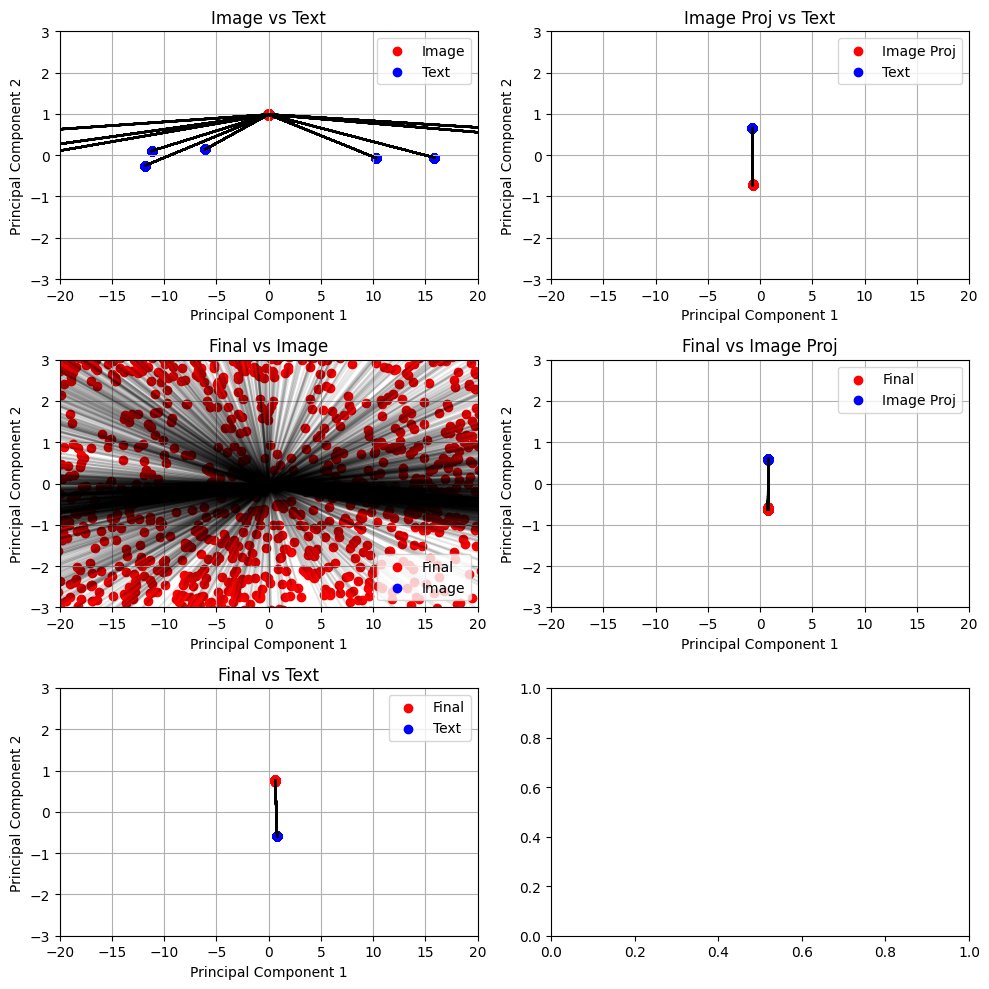

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function for dimensionality reduction using SVD
def svd(X, n_components=2):
    X = X.astype(np.float32)  # Ensure data type compatibility
    U, S, Vt = np.linalg.svd(X)
    return U[:, :n_components] * S[:n_components]

# Function to compute 2D projections for all feature pairs
def compute_projections(feature_pairs):
    projected_features = {}
    for label, (features1, features2) in feature_pairs.items():
        combined_features = np.concatenate((features1, features2), axis=0)
        features_2d = svd(combined_features)
        # Split the 2D features back into two sets
        features_2d1 = features_2d[:features1.shape[0]]
        features_2d2 = features_2d[features1.shape[0]:]
        projected_features[label] = (features_2d1, features_2d2)
    return projected_features


# Define feature pairs
feature_pairs = {
    "Image vs Text": (image_features, reduced_features),
    "Image Proj vs Text": (image_features_proj, text_features),
    "Final vs Image": (final_embeddings_reduced, image_features),
    "Final vs Image Proj": (final_embeddings, image_features_proj),
    "Final vs Text": (final_embeddings, text_features),
}

# Compute projections
projected_features = compute_projections(feature_pairs)



# Function to create a scatter plot for two sets of features
def plot_features(ax, features_2d1, features_2d2, label1, label2, xlim, ylim):
    ax.scatter(features_2d1[:, 0], features_2d1[:, 1], c='red', label=label1)
    ax.scatter(features_2d2[:, 0], features_2d2[:, 1], c='blue', label=label2)

    # Connect the dots
    for i in range(len(features_2d1)):
        ax.plot([features_2d1[i, 0], features_2d2[i, 0]], 
                 [features_2d1[i, 1], features_2d2[i, 1]], 
                 c='black', alpha=0.1)

    ax.legend()
    ax.set_title(f"{label1} vs {label2}")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid()


# Calculate global x and y limits
x_vals = np.concatenate([np.concatenate((f1[:, 0], f2[:, 0])) for f1, f2 in projected_features.values()])
y_vals = np.concatenate([np.concatenate((f1[:, 1], f2[:, 1])) for f1, f2 in projected_features.values()])
xlim = (-20, 20)
ylim = (-3, 3)

# Visualization
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()

# Plot each feature pair
for i, (label, (features_2d1, features_2d2)) in enumerate(projected_features.items()):
    if i >= len(axs): break  # Prevents indexing errors if there are more plots than subplots
    plot_features(axs[i], features_2d1, features_2d2, label.split(" vs ")[0], label.split(" vs ")[1], xlim, ylim)

# Adjust layout
plt.tight_layout()
plt.show()

In [6]:
# compute euclidean distance between reduced features and image features
from sklearn.metrics.pairwise import euclidean_distances
# use standard scaler to normalize all the features
#scaler = StandardScaler()
#reduced_features = scaler.fit_transform(reduced_features)
#image_features = scaler.fit_transform(image_features)
#text_features = scaler.fit_transform(text_features)
#final_embeddings_reduced = scaler.fit_transform(final_embeddings_reduced)


# Compute pairwise Euclidean distances between reduced features and image features
distances_1 = euclidean_distances(reduced_features, image_features).mean()
distances_2 = euclidean_distances(final_embeddings_reduced, image_features).mean()
distances_3 = euclidean_distances(final_embeddings, text_features).mean()
distances_4 = euclidean_distances(text_features, image_features_proj).mean()

print("Pairwise Euclidean Distances:")
print(f"Text Features vs Image Features: {distances_1}")
print(f"Final Embeddings vs Image Features (Projected): {distances_4}")
print(f"Final Embeddings vs Image Features: {distances_2}")
print(f"Text Features vs Text Features: {distances_3}")

# compute cosine similarity between reduced features and image features
from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise cosine similarity between reduced features and image features
similarities_1 = cosine_similarity(reduced_features, image_features).mean()
similarities_2 = cosine_similarity(final_embeddings_reduced, image_features).mean()
similarities_3 = cosine_similarity(final_embeddings, text_features).mean()
similarities_4 = cosine_similarity(text_features, image_features_proj).mean()
print(" ")
print("Pairwise Cosine Similarities:")
print(f"Text Features vs Image Features: {similarities_1}")
print(f"Text Features vs Image Features (Projected): {similarities_4}")
print(f"Final Embeddings vs Image Features: {similarities_2}")
print(f"Final Embeddings vs Text Features: {similarities_3}")

Pairwise Euclidean Distances:
Text Features vs Image Features: 26.305675973484355
Final Embeddings vs Image Features (Projected): 1.3812969233857864
Final Embeddings vs Image Features: 26.779308256868962
Text Features vs Text Features: 1.3712167293701636
 
Pairwise Cosine Similarities:
Text Features vs Image Features: 0.0028770295135005963
Text Features vs Image Features (Projected): 0.045919748733844704
Final Embeddings vs Image Features: 0.0008256905675515015
Final Embeddings vs Text Features: 0.05979257188049665


In [21]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize a dictionary to store Cosine similarities for each target
target_cosine_similarities = {target: [] for target in set(item["target"] for item in model_answers)}

# Initialize the column names (feature pairs)
feature_pairs = [
    "image_features_proj_vs_text_features",
    "image_features_vs_reduced_features",
    "final_embeddings_vs_image_features_proj",
    "final_embeddings_vs_text_features",
    "final_embeddings_reduced_vs_image_features"
]

# Loop over the model_answers and compute Cosine similarity for each pair
for i, answer in enumerate(model_answers):
    target = answer["target"]
    
    # Extract corresponding features for this target
    text_feat = text_features[i]
    image_feat = image_features[i]
    image_feat_proj = image_features_proj[i]
    reduced_feat = reduced_features[i]  # assuming reduced_features is the same as image_features_proj for this example
    final_feat = final_embeddings[i]
    final_feat_reduced = final_embeddings_reduced[i]  # assuming final_embeddings_reduced is the same as final_embeddings for this example
    
    # Compute Cosine similarities between all pairs
    cos_sim_image_proj_vs_text = cosine_similarity([image_feat_proj], [text_feat])[0][0]
    cos_sim_image_vs_reduced = cosine_similarity([image_feat], [reduced_feat])[0][0]
    cos_sim_final_vs_image_proj = cosine_similarity([final_feat], [image_feat_proj])[0][0]
    cos_sim_final_vs_text = cosine_similarity([final_feat], [text_feat])[0][0]
    cos_sim_final_reduced_vs_image = cosine_similarity([final_feat_reduced], [image_feat])[0][0]
    
    # Append the similarities to the corresponding target's entry
    target_cosine_similarities[target].append([
        cos_sim_image_proj_vs_text,
        cos_sim_image_vs_reduced,
        cos_sim_final_vs_image_proj,
        cos_sim_final_vs_text,
        cos_sim_final_reduced_vs_image
    ])

# Print out the table
# First, print the header row (VS pairs)
print(f"{'Target':<10} {'image_features_proj_vs_text_features':<30} {'image_features_vs_reduced_features':<30} {'final_embeddings_vs_image_features_proj':<40} {'final_embeddings_vs_text_features':<40} {'final_embeddings_reduced_vs_image_features':<40}")

# Then, for each target, print the Cosine similarities for each pair
for target, similarities in target_cosine_similarities.items():
    # Compute the average Cosine similarity for each pair for the given target
    avg_similarities = np.mean(similarities, axis=0)
    print(f"{target:<10} {avg_similarities[0]:<30.4f} {avg_similarities[1]:<30.4f} {avg_similarities[2]:<40.4f} {avg_similarities[3]:<40.4f} {avg_similarities[4]:<40.4f}")


Target     image_features_proj_vs_text_features image_features_vs_reduced_features final_embeddings_vs_image_features_proj  final_embeddings_vs_text_features        final_embeddings_reduced_vs_image_features
1          0.0440                         -0.0150                        0.2583                                   0.0586                                   -0.0094                                 
2          0.0432                         -0.0165                        0.2559                                   0.0590                                   -0.0077                                 
3          0.0429                         -0.0145                        0.2573                                   0.0589                                   0.0023                                  
4          0.0444                         -0.0157                        0.2552                                   0.0594                                   -0.0007                                 
5       

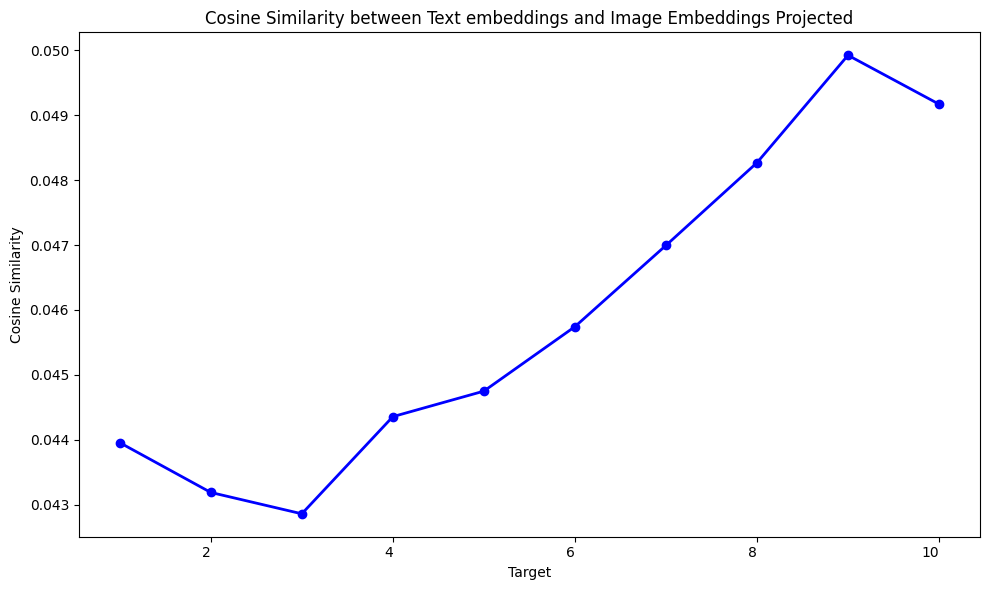

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the final_embeddings_vs_image_features_proj similarities for each target
targets = []
cosine_similarities_final_vs_image_proj = []

# Loop over the target_cosine_similarities dictionary and extract the needed values
for target, similarities in target_cosine_similarities.items():
    # Compute the average cosine similarity for the pair final_embeddings_vs_image_features_proj
    avg_sim_final_vs_image_proj = np.mean([sim[0] for sim in similarities])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    cosine_similarities_final_vs_image_proj.append(avg_sim_final_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_cosine_similarities = np.array(cosine_similarities_final_vs_image_proj)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_cosine_similarities, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Text embeddings and Image Embeddings Projected')
plt.xticks(rotation=0, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


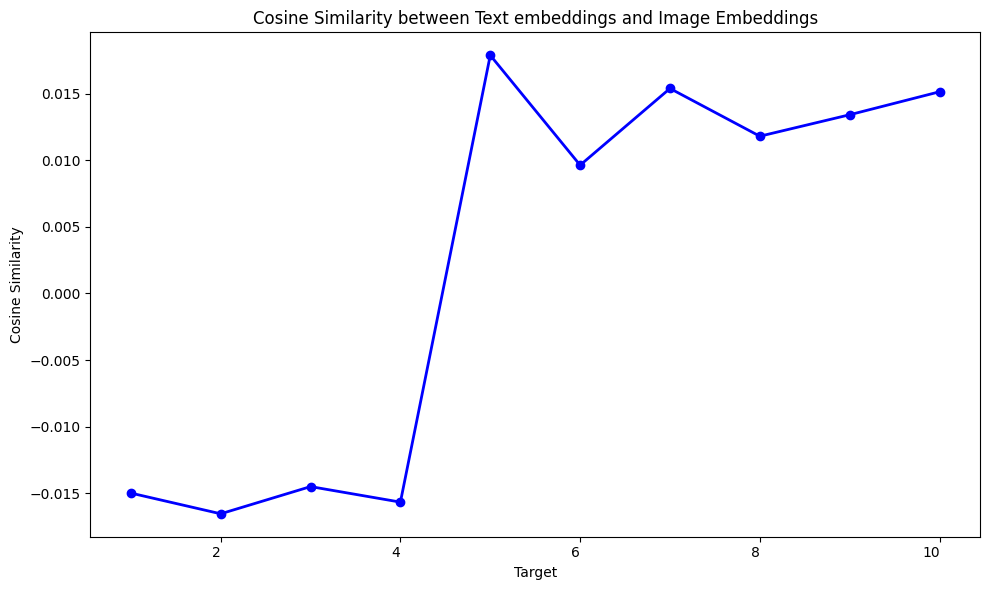

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the final_embeddings_vs_image_features_proj similarities for each target
targets = []
cosine_similarities_final_vs_image_proj = []

# Loop over the target_cosine_similarities dictionary and extract the needed values
for target, similarities in target_cosine_similarities.items():
    # Compute the average cosine similarity for the pair final_embeddings_vs_image_features_proj
    avg_sim_final_vs_image_proj = np.mean([sim[1] for sim in similarities])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    cosine_similarities_final_vs_image_proj.append(avg_sim_final_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_cosine_similarities = np.array(cosine_similarities_final_vs_image_proj)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_cosine_similarities, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Text embeddings and Image Embeddings')
plt.xticks(rotation=0, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


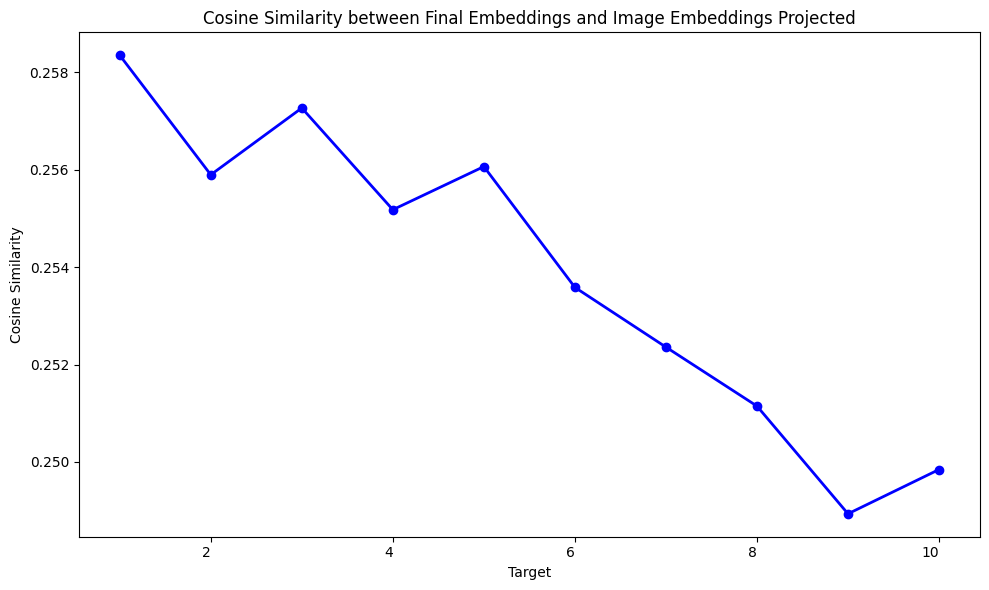

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the final_embeddings_vs_image_features_proj similarities for each target
targets = []
cosine_similarities_final_vs_image_proj = []

# Loop over the target_cosine_similarities dictionary and extract the needed values
for target, similarities in target_cosine_similarities.items():
    # Compute the average cosine similarity for the pair final_embeddings_vs_image_features_proj
    avg_sim_final_vs_image_proj = np.mean([sim[2] for sim in similarities])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    cosine_similarities_final_vs_image_proj.append(avg_sim_final_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_cosine_similarities = np.array(cosine_similarities_final_vs_image_proj)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_cosine_similarities, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Final Embeddings and Image Embeddings Projected')
plt.xticks(rotation=0, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


In [25]:
import numpy as np
from scipy.spatial.distance import euclidean

# Initialize a dictionary to store Euclidean distances for each target
target_euclidean_distances = {target: [] for target in set(item["target"] for item in model_answers)}

# Initialize the column names (feature pairs)
feature_pairs = [
    "image_features_proj_vs_text_features",
    "image_features_vs_reduced_features",
    "final_embeddings_vs_image_features_proj",
    "final_embeddings_vs_text_features",
    "final_embeddings_reduced_vs_image_features"
]

# Loop over the model_answers and compute Euclidean distance for each pair
for i, answer in enumerate(model_answers):
    target = answer["target"]
    
    # Extract corresponding features for this target
    text_feat = text_features[i]
    image_feat = image_features[i]
    image_feat_proj = image_features_proj[i]
    reduced_feat = reduced_features[i]  # assuming reduced_features is the same as image_features_proj for this example
    final_feat = final_embeddings[i]
    final_feat_reduced = final_embeddings_reduced[i]  # assuming final_embeddings_reduced is the same as final_embeddings for this example
    
    # Compute Euclidean distances between all pairs
    eucl_dist_image_proj_vs_text = euclidean(image_feat_proj, text_feat)
    eucl_dist_image_vs_reduced = euclidean(image_feat, reduced_feat)
    eucl_dist_final_vs_image_proj = euclidean(final_feat, image_feat_proj)
    eucl_dist_final_vs_text = euclidean(final_feat, text_feat)
    eucl_dist_final_reduced_vs_image = euclidean(final_feat_reduced, image_feat)
    
    # Append the distances to the corresponding target's entry
    target_euclidean_distances[target].append([
        eucl_dist_image_proj_vs_text,
        eucl_dist_image_vs_reduced,
        eucl_dist_final_vs_image_proj,
        eucl_dist_final_vs_text,
        eucl_dist_final_reduced_vs_image
    ])

# Print out the table
# First, print the header row (VS pairs)
print(f"{'Target':<10} {'image_features_proj_vs_text_features':<30} {'image_features_vs_reduced_features':<30} {'final_embeddings_vs_image_features_proj':<40} {'final_embeddings_vs_text_features':<40} {'final_embeddings_reduced_vs_image_features':<40}")

# Then, for each target, print the Euclidean distances for each pair
for target, distances in target_euclidean_distances.items():
    # Compute the average Euclidean distance for each pair for the given target
    avg_distances = np.mean(distances, axis=0)
    print(f"{target:<10} {avg_distances[0]:<30.4f} {avg_distances[1]:<30.4f} {avg_distances[2]:<40.4f} {avg_distances[3]:<40.4f} {avg_distances[4]:<40.4f}")


Target     image_features_proj_vs_text_features image_features_vs_reduced_features final_embeddings_vs_image_features_proj  final_embeddings_vs_text_features        final_embeddings_reduced_vs_image_features
1          1.3829                         44.6559                        1.2179                                   1.3722                                   21.3011                                 
2          1.3834                         15.9403                        1.2199                                   1.3718                                   23.3901                                 
3          1.3835                         10.4551                        1.2188                                   1.3718                                   22.2104                                 
4          1.3828                         60.2429                        1.2204                                   1.3718                                   25.4569                                 
5       

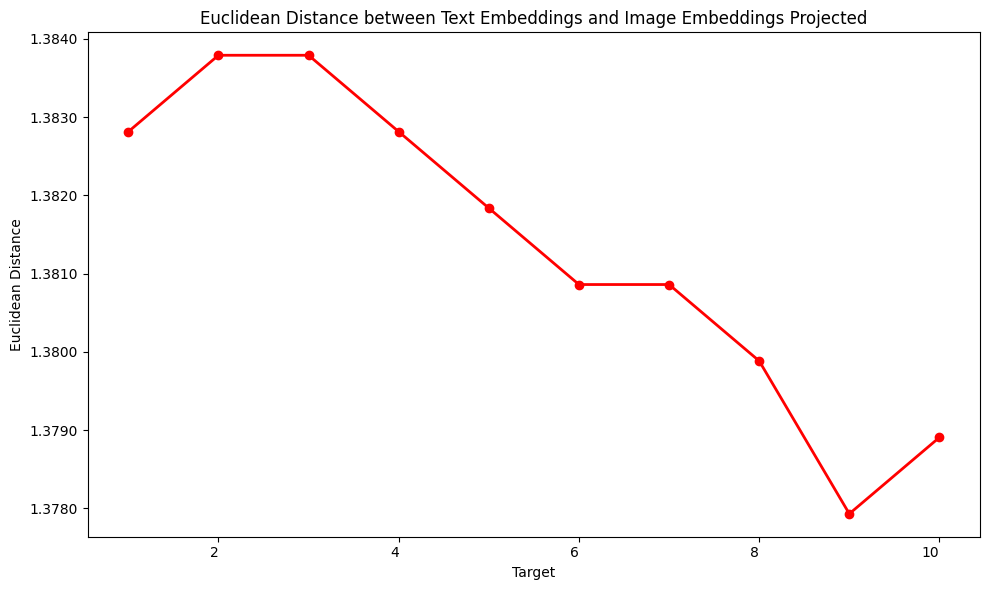

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean

# Extract the Euclidean distances for final_embeddings_vs_image_features_proj for each target
targets = []
euclidean_distances_text_vs_image = []

# Loop over the target_euclidean_distances dictionary and extract the needed values
for target, distances in target_euclidean_distances.items():
    # Compute the average Euclidean distance for the pair final_embeddings_vs_image_features_proj
    avg_dist_text_vs_image_proj = np.mean([dist[0] for dist in distances])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    euclidean_distances_text_vs_image.append(avg_dist_text_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_euclidean_distances = np.array(euclidean_distances_text_vs_image)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_euclidean_distances, marker='o', color='r', linestyle='-', linewidth=2, markersize=6)

import matplotlib.ticker as mticker

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance between Text Embeddings and Image Embeddings Projected')
plt.xticks(rotation=0, ha='right')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.4f}"))  # Display with 4 decimal places
# Display the plot
plt.tight_layout()
plt.show()




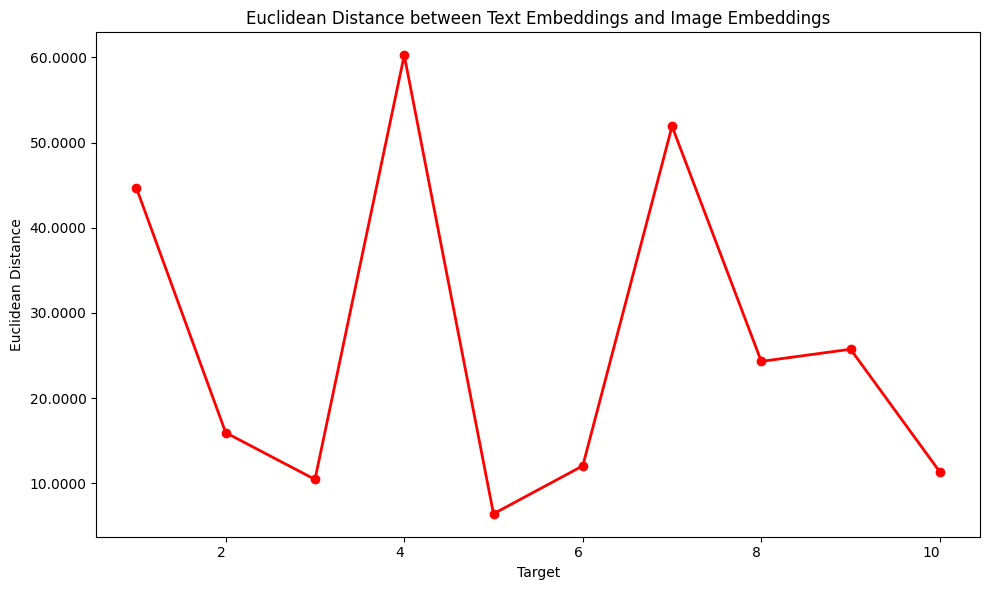

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean

# Extract the Euclidean distances for final_embeddings_vs_image_features_proj for each target
targets = []
euclidean_distances_text_vs_image = []

# Loop over the target_euclidean_distances dictionary and extract the needed values
for target, distances in target_euclidean_distances.items():
    # Compute the average Euclidean distance for the pair final_embeddings_vs_image_features_proj
    avg_dist_text_vs_image_proj = np.mean([dist[1] for dist in distances])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    euclidean_distances_text_vs_image.append(avg_dist_text_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_euclidean_distances = np.array(euclidean_distances_text_vs_image)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_euclidean_distances, marker='o', color='r', linestyle='-', linewidth=2, markersize=6)

import matplotlib.ticker as mticker

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance between Text Embeddings and Image Embeddings')
plt.xticks(rotation=0, ha='right')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.4f}"))  # Display with 4 decimal places
# Display the plot
plt.tight_layout()
plt.show()




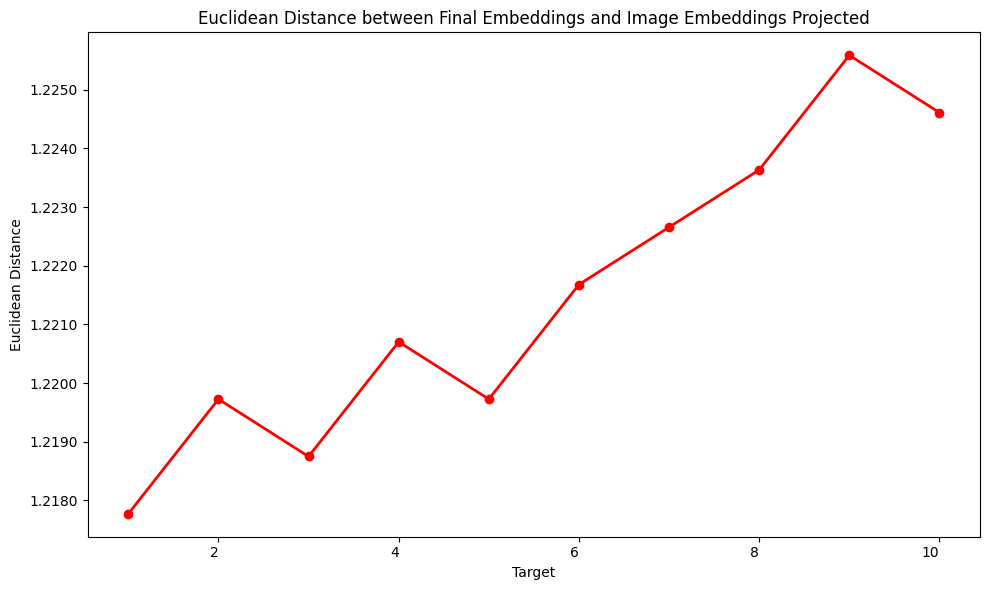

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean

# Extract the Euclidean distances for final_embeddings_vs_image_features_proj for each target
targets = []
euclidean_distances_text_vs_image = []

# Loop over the target_euclidean_distances dictionary and extract the needed values
for target, distances in target_euclidean_distances.items():
    # Compute the average Euclidean distance for the pair final_embeddings_vs_image_features_proj
    avg_dist_text_vs_image_proj = np.mean([dist[2] for dist in distances])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    euclidean_distances_text_vs_image.append(avg_dist_text_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_euclidean_distances = np.array(euclidean_distances_text_vs_image)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_euclidean_distances, marker='o', color='r', linestyle='-', linewidth=2, markersize=6)

import matplotlib.ticker as mticker

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance between Final Embeddings and Image Embeddings Projected')
plt.xticks(rotation=0, ha='right')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.4f}"))  # Display with 4 decimal places
# Display the plot
plt.tight_layout()
plt.show()




# LLAVA Answers

In [46]:
import torch
import pickle

# Define file paths (adjust if they're in a specific folder)
final_embeddings_path = "final_embeddings.pt"
image_features_path = "image_features.pt"
image_features_proj_path = "image_features_proj.pt"
model_answers_path = "model_answers.pkl"
text_features_path = "text_features.pt"

# Load the .pt files using PyTorch
final_embeddings = torch.load(final_embeddings_path)
image_features = torch.load(image_features_path)
image_features_proj = torch.load(image_features_proj_path)
text_features = torch.load(text_features_path)

# Load the .pkl file using pickle
with open(model_answers_path, "rb") as f:
    model_answers = pickle.load(f)

# Print loaded data for verification
print("Final Embeddings:", type(final_embeddings))
print("Image Features:", type(image_features))
print("Image Features (Projected):", type(image_features_proj))
print("Text Features:", type(text_features))
print("Model Answers:", type(model_answers))

# convert everithing to numpy
final_embeddings = final_embeddings.cpu().numpy()
image_features = image_features.cpu().numpy()
image_features_proj = image_features_proj.cpu().numpy()
text_features = text_features.cpu().numpy()


C:\Users\matti\AppData\Local\Temp\ipykernel_7412\42748697.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_embeddings = torch.load(final_embeddings_path)
C:\Users\

Final Embeddings: <class 'torch.Tensor'>
Image Features: <class 'torch.Tensor'>
Image Features (Projected): <class 'torch.Tensor'>
Text Features: <class 'torch.Tensor'>
Model Answers: <class 'list'>


Category-wise Accuracy:
people: 35.00%
apples: 33.40%
fastcards: 35.60%
butterflies: 32.60%
dots: 20.60%


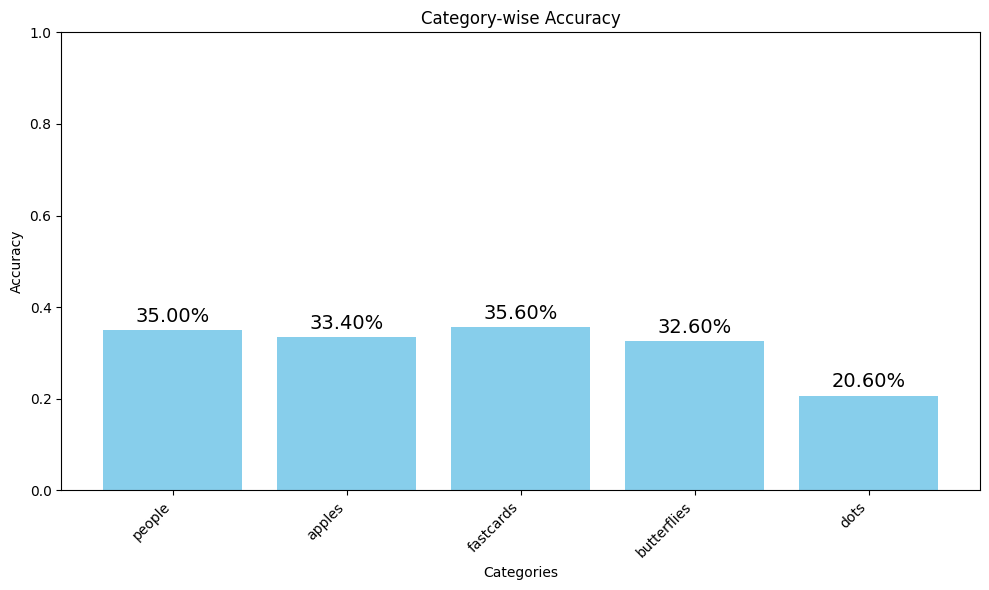

In [34]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Initialize variables
category_correct = defaultdict(int)
category_total = defaultdict(int)

# Loop through the model answers
for item in model_answers:
    category = item["category"]
    target = item["target"]
    predicted_number = int(item["predicted_number"])  # Ensure it's an integer
    
    # Update counts
    if predicted_number == target:
        category_correct[category] += 1
    category_total[category] += 1

# Compute accuracy for each category
category_accuracy = {
    category: category_correct[category] / category_total[category]
    for category in category_total
}

# Print results
print("Category-wise Accuracy:")
for category, accuracy in category_accuracy.items():
    print(f"{category}: {accuracy:.2%}")

# Data for plotting
categories = list(category_accuracy.keys())
accuracies = list(category_accuracy.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, accuracies, color='skyblue')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Accuracy')
plt.title('Category-wise Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate category names for readability
plt.ylim(0, 1)  # Accuracy scale from 0 to 1

# Add accuracy numbers on top of each bar with larger font size
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (accuracy value)
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2%}', 
             ha='center', va='bottom', fontsize=14, color='black')  # Increased fontsize

# Display the plot
plt.tight_layout()
plt.show()



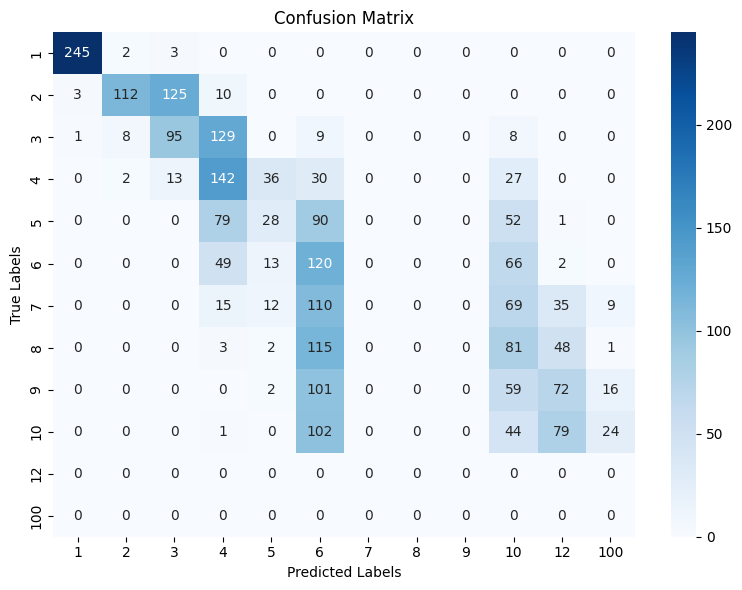

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extract the true labels (targets) and predicted labels
y_true = [item["target"] for item in model_answers]
y_pred = [int(item["predicted_number"]) for item in model_answers]  # Convert to integers

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get the unique categories from both true and predicted labels
all_labels = np.unique(np.concatenate([y_true, y_pred]))

# Create a heatmap for the confusion matrix with a color bar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels, cbar=True)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.tight_layout()
plt.show()


Mean Absolute Error (MAE) per Category:
Category 4: 1.10
Category 5: 1.74
Category 3: 0.89
Category 9: 8.17
Category 8: 2.78
Category 7: 5.59
Category 1: 0.03
Category 6: 1.55
Category 10: 10.93
Category 2: 0.59


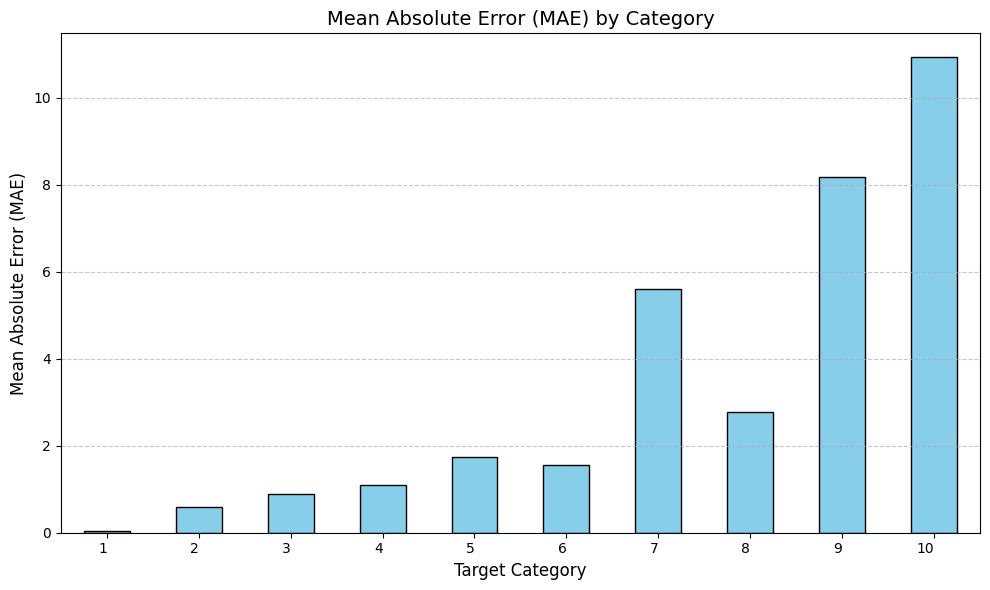

In [36]:
import numpy as np

# Initialize dictionaries to store the absolute errors and counts per category
errors = defaultdict(list)

# Loop through the model answers to compute absolute errors per category
for item in model_answers:
    target = item["target"]
    predicted_number = int(item["predicted_number"])  # Convert to integer
    absolute_error = abs(predicted_number - target)
    errors[target].append(absolute_error)

# Compute MAE for each category
mae_per_category = {category: np.mean(error_list) for category, error_list in errors.items()}

# Print MAE for each category
print("Mean Absolute Error (MAE) per Category:")
for category, mae in mae_per_category.items():
    print(f"Category {category}: {mae:.2f}")


import matplotlib.pyplot as plt
import pandas as pd

# Assuming mae_per_category is a dictionary with categories as keys and MAE as values
mae_by_category = pd.Series(mae_per_category).sort_index()

# Plotting MAE by category
plt.figure(figsize=(10, 6))
mae_by_category.plot(kind='bar', color='skyblue', edgecolor='black')

# Add plot details
plt.title("Mean Absolute Error (MAE) by Category", fontsize=14)
plt.xlabel("Target Category", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.xticks(rotation=0, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()



In [47]:
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assuming text_features is already a PyTorch tensor of shape (N, 4096)
text_features = text_features  # Move to the GPU if available
seed = 42
torch.manual_seed(seed)
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.Sigmoid()  # Adjust based on your data range
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize the model, criterion, and optimizer
autoencoder = Autoencoder().to(device) # Ensure model is on the correct device
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the Autoencoder
num_epochs = 1
batch_size = 64
data_loader = torch.utils.data.DataLoader(text_features, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for data in data_loader:
        optimizer.zero_grad()
        data = data.to(device).float()  # Move data to GPU if available
        encoded, decoded = autoencoder(data)
        loss = criterion(decoded, data)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Use the Encoder for Dimensionality Reduction
with torch.no_grad():
    reduced_features = autoencoder.encoder(torch.tensor(text_features).float().to(device))
    
reduced_features.shape


# Assuming text_features is already a PyTorch tensor of shape (N, 4096)
final_embeddings = final_embeddings  # Move to the GPU if available

# Define the Autoencoder for final_embeddings
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.Sigmoid()  # Adjust based on your data range
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize the model, criterion, and optimizer
autoencoder = Autoencoder().to(device)  # Ensure model is on the correct device
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the Autoencoder
num_epochs = 1
batch_size = 64
data_loader = torch.utils.data.DataLoader(text_features, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for data in data_loader:
        optimizer.zero_grad()
        data = data.to(device).float()  # Move data to GPU if available
        encoded, decoded = autoencoder(data)
        loss = criterion(decoded, data)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Use the Encoder for Dimensionality Reduction
with torch.no_grad():
    final_embeddings_reduced = autoencoder.encoder(torch.tensor(final_embeddings).float().to(device))

reduced_features = reduced_features.cpu().numpy()
final_embeddings_reduced = final_embeddings_reduced.cpu().numpy()

Epoch [1/1], Loss: 0.0002
Epoch [1/1], Loss: 0.0002


In [38]:
# normalize reduced_features and final_embeddings_reduced
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
reduced_features = scaler.fit_transform(reduced_features)
final_embeddings_reduced = scaler.fit_transform(final_embeddings_reduced)


In [97]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming text_features and final_embeddings are already PyTorch tensors of shape (N, 4096)

# Move data to the CPU for PCA since sklearn doesn't support GPU


# Initialize PCA
pca_text = PCA(n_components=1024)  # Set the number of components you want for text_features
pca_final = PCA(n_components=1024)  # Set the number of components you want for final_embeddings

# Perform PCA on text_features and final_embeddings separately
text_features_pca = pca_text.fit_transform(text_features)
final_embeddings_pca = pca_final.fit_transform(final_embeddings)

# Convert reduced features back to PyTorch tensors if needed
reduced_features = torch.tensor(text_features_pca).float()
final_embeddings_reduced = torch.tensor(final_embeddings_pca).float()

# Optionally, print the shape of the reduced features
print(f"Reduced text features shape: {reduced_features.shape}")
print(f"Reduced final embeddings shape: {final_embeddings_reduced.shape}")


c:\Users\matti\Documents\GitHub\Modality-Gap\.conda\Lib\site-packages\sklearn\decomposition\_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Reduced text features shape: torch.Size([2500, 1024])
Reduced final embeddings shape: torch.Size([2500, 1024])


In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Function for dimensionality reduction using SVD
def svd(X, n_components=2):
    X = X.astype(np.float32)  # Ensure data type compatibility
    U, S, Vt = np.linalg.svd(X)
    return U[:, :n_components] * S[:n_components]

# Function to compute 2D projections for all feature pairs
def compute_projections(feature_pairs):
    projected_features = {}
    for label, (features1, features2) in feature_pairs.items():
        combined_features = np.concatenate((features1, features2), axis=0)
        features_2d = svd(combined_features)
        # Split the 2D features back into two sets
        features_2d1 = features_2d[:features1.shape[0]]
        features_2d2 = features_2d[features1.shape[0]:]
        projected_features[label] = (features_2d1, features_2d2)
    return projected_features


# Define feature pairs
feature_pairs = {
    "Image vs Text": (image_features, reduced_features),
    "Image Proj vs Text": (image_features_proj, text_features),
    "Final vs Image": (final_embeddings_reduced, image_features),
    "Final vs Image Proj": (final_embeddings, image_features_proj),
    "Final vs Text": (final_embeddings, text_features),
}

# Compute projections
projected_features = compute_projections(feature_pairs)



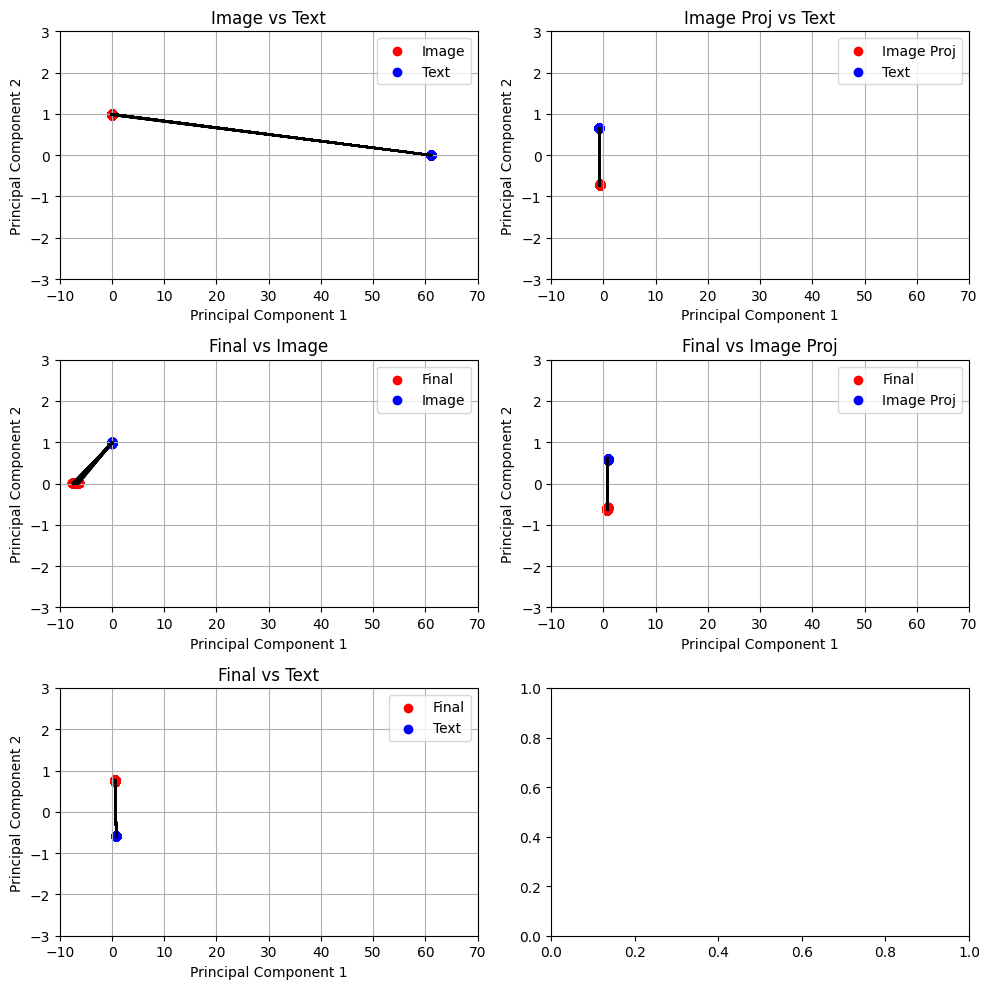

In [53]:
# Function to create a scatter plot for two sets of features
def plot_features(ax, features_2d1, features_2d2, label1, label2, xlim, ylim):
    ax.scatter(features_2d1[:, 0], features_2d1[:, 1], c='red', label=label1)
    ax.scatter(features_2d2[:, 0], features_2d2[:, 1], c='blue', label=label2)

    # Connect the dots
    for i in range(len(features_2d1)):
        ax.plot([features_2d1[i, 0], features_2d2[i, 0]], 
                 [features_2d1[i, 1], features_2d2[i, 1]], 
                 c='black', alpha=0.1)

    ax.legend()
    ax.set_title(f"{label1} vs {label2}")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid()


# Calculate global x and y limits
x_vals = np.concatenate([np.concatenate((f1[:, 0], f2[:, 0])) for f1, f2 in projected_features.values()])
y_vals = np.concatenate([np.concatenate((f1[:, 1], f2[:, 1])) for f1, f2 in projected_features.values()])
xlim = (-10, +70)
ylim = (-3, 3)

# Visualization
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()

# Plot each feature pair
for i, (label, (features_2d1, features_2d2)) in enumerate(projected_features.items()):
    if i >= len(axs): break  # Prevents indexing errors if there are more plots than subplots
    plot_features(axs[i], features_2d1, features_2d2, label.split(" vs ")[0], label.split(" vs ")[1], xlim, ylim)

# Adjust layout
plt.tight_layout()
plt.show()

In [51]:
# compute euclidean distance between reduced features and image features
from sklearn.metrics.pairwise import euclidean_distances
# use standard scaler to normalize all the features
#scaler = StandardScaler()
#reduced_features = scaler.fit_transform(reduced_features)
#image_features = scaler.fit_transform(image_features)
#text_features = scaler.fit_transform(text_features)
#final_embeddings_reduced = scaler.fit_transform(final_embeddings_reduced)


# Compute pairwise Euclidean distances between reduced features and image features
distances_1 = euclidean_distances(reduced_features, image_features).mean()
distances_2 = euclidean_distances(final_embeddings_reduced, image_features).mean()
distances_3 = euclidean_distances(final_embeddings, text_features).mean()
distances_4 = euclidean_distances(text_features, image_features_proj).mean()

print("Pairwise Euclidean Distances:")
print(f"Reduced Features vs Image Features: {distances_1}")
print(f"Final Embeddings vs Image Features: {distances_2}")
print(f"Final Embeddings vs Text Features: {distances_3}")
print(f"Text Features vs Image Features (Projected): {distances_4}")

# compute cosine similarity between reduced features and image features
from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise cosine similarity between reduced features and image features
similarities_1 = cosine_similarity(reduced_features, image_features).mean()
similarities_2 = cosine_similarity(final_embeddings_reduced, image_features).mean()
similarities_3 = cosine_similarity(final_embeddings, text_features).mean()
similarities_4 = cosine_similarity(text_features, image_features_proj).mean()

print("Pairwise Cosine Similarities:")
print(f"Text Features vs Image Features: {similarities_1}")
print(f"Text Features vs Image Features (Projected): {similarities_4}")
print(f"Final Embeddings vs Image Features: {similarities_2}")
print(f"Final Embeddings vs Text Features: {similarities_3}")




targets = [item["target"] for item in model_answers]


Pairwise Euclidean Distances:
Reduced Features vs Image Features: 61.097446781146566
Final Embeddings vs Image Features: 7.079152413223626
Final Embeddings vs Text Features: 1.3706647684202418
Text Features vs Image Features (Projected): 1.3815973349524668
Pairwise Cosine Similarities:
Text Features vs Image Features: -0.01710264123626081
Text Features vs Image Features (Projected): 0.045570349843703936
Final Embeddings vs Image Features: -0.022822971803912413
Final Embeddings vs Text Features: 0.06061568946848056


In [54]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize dictionaries to store cosine similarities for each pair
pairwise_cosine_similarities = {
    "image_features_proj_vs_text_features": [],
    "image_features_vs_reduced_features": [],
    "final_embeddings_vs_image_features_proj": [],
    "final_embeddings_vs_text_features": [],
    "final_embeddings_reduced_vs_image_features": []
}

# Loop over the model_answers and compute cosine similarity for each pair
for i, answer in enumerate(model_answers):
    target = answer["target"]
    
    # Extract corresponding features for this target
    text_feat = text_features[i]
    image_feat = image_features[i]
    image_feat_proj = image_features_proj[i]
    reduced_feat = reduced_features[i]  # assuming reduced_features is the same as image_features_proj for this example
    final_feat = final_embeddings[i]
    final_feat_reduced = final_embeddings_reduced[i]  # assuming final_embeddings_reduced is the same as final_embeddings for this example
    
    # Compute cosine similarities between all pairs
    cos_sim_image_proj_vs_text = cosine_similarity([image_feat_proj], [text_feat])[0][0]
    cos_sim_image_vs_reduced = cosine_similarity([image_feat], [reduced_feat])[0][0]
    cos_sim_final_vs_image_proj = cosine_similarity([final_feat], [image_feat_proj])[0][0]
    cos_sim_final_vs_text = cosine_similarity([final_feat], [text_feat])[0][0]
    cos_sim_final_reduced_vs_image = cosine_similarity([final_feat_reduced], [image_feat])[0][0]
    
    # Append cosine similarities to the respective lists in the dictionary
    pairwise_cosine_similarities["image_features_proj_vs_text_features"].append(cos_sim_image_proj_vs_text)
    pairwise_cosine_similarities["image_features_vs_reduced_features"].append(cos_sim_image_vs_reduced)
    pairwise_cosine_similarities["final_embeddings_vs_image_features_proj"].append(cos_sim_final_vs_image_proj)
    pairwise_cosine_similarities["final_embeddings_vs_text_features"].append(cos_sim_final_vs_text)
    pairwise_cosine_similarities["final_embeddings_reduced_vs_image_features"].append(cos_sim_final_reduced_vs_image)

# Compute average cosine similarity for each pair
pairwise_avg_cosine_similarities = {
    pair: np.mean(cos_sim_list)
    for pair, cos_sim_list in pairwise_cosine_similarities.items()
}

# Print the average cosine similarities for each pair
for pair, avg_cos_sim in pairwise_avg_cosine_similarities.items():
    print(f"Pair: {pair}, Average Cosine Similarity: {avg_cos_sim:.4f}")


Pair: image_features_proj_vs_text_features, Average Cosine Similarity: 0.0456
Pair: image_features_vs_reduced_features, Average Cosine Similarity: -0.0171
Pair: final_embeddings_vs_image_features_proj, Average Cosine Similarity: 0.2532
Pair: final_embeddings_vs_text_features, Average Cosine Similarity: 0.0606
Pair: final_embeddings_reduced_vs_image_features, Average Cosine Similarity: -0.0228


In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean

# Initialize dictionaries to store Euclidean distances for each pair
pairwise_euclidean_distances = {
    "image_features_proj_vs_text_features": [],
    "image_features_vs_reduced_features": [],
    "final_embeddings_vs_image_features_proj": [],
    "final_embeddings_vs_text_features": [],
    "final_embeddings_reduced_vs_image_features": []
}

# Loop over the model_answers and compute Euclidean distance for each pair
for i, answer in enumerate(model_answers):
    target = answer["target"]
    
    # Extract corresponding features for this target
    text_feat = text_features[i]
    image_feat = image_features[i]
    image_feat_proj = image_features_proj[i]
    reduced_feat = reduced_features[i]  # assuming reduced_features is the same as image_features_proj for this example
    final_feat = final_embeddings[i]
    final_feat_reduced = final_embeddings_reduced[i]  # assuming final_embeddings_reduced is the same as final_embeddings for this example
    
    # Compute Euclidean distances between all pairs
    eucl_dist_image_proj_vs_text = euclidean(image_feat_proj, text_feat)
    eucl_dist_image_vs_reduced = euclidean(image_feat, reduced_feat)
    eucl_dist_final_vs_image_proj = euclidean(final_feat, image_feat_proj)
    eucl_dist_final_vs_text = euclidean(final_feat, text_feat)
    eucl_dist_final_reduced_vs_image = euclidean(final_feat_reduced, image_feat)
    
    # Append Euclidean distances to the respective lists in the dictionary
    pairwise_euclidean_distances["image_features_proj_vs_text_features"].append(eucl_dist_image_proj_vs_text)
    pairwise_euclidean_distances["image_features_vs_reduced_features"].append(eucl_dist_image_vs_reduced)
    pairwise_euclidean_distances["final_embeddings_vs_image_features_proj"].append(eucl_dist_final_vs_image_proj)
    pairwise_euclidean_distances["final_embeddings_vs_text_features"].append(eucl_dist_final_vs_text)
    pairwise_euclidean_distances["final_embeddings_reduced_vs_image_features"].append(eucl_dist_final_reduced_vs_image)

# Compute average Euclidean distance for each pair
pairwise_avg_euclidean_distances = {
    pair: np.mean(dist_list)
    for pair, dist_list in pairwise_euclidean_distances.items()
}

# Print the average Euclidean distances for each pair
for pair, avg_eucl_dist in pairwise_avg_euclidean_distances.items():
    print(f"Pair: {pair}, Average Euclidean Distance: {avg_eucl_dist:.4f}")


Pair: image_features_proj_vs_text_features, Average Euclidean Distance: 1.3818
Pair: image_features_vs_reduced_features, Average Euclidean Distance: 56.2426
Pair: final_embeddings_vs_image_features_proj, Average Euclidean Distance: 1.2217
Pair: final_embeddings_vs_text_features, Average Euclidean Distance: 1.3701
Pair: final_embeddings_reduced_vs_image_features, Average Euclidean Distance: 7.5269


In [55]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize a dictionary to store Cosine similarities for each target
target_cosine_similarities = {target: [] for target in set(item["target"] for item in model_answers)}

# Initialize the column names (feature pairs)
feature_pairs = [
    "image_features_proj_vs_text_features",
    "image_features_vs_reduced_features",
    "final_embeddings_vs_image_features_proj",
    "final_embeddings_vs_text_features",
    "final_embeddings_reduced_vs_image_features"
]

# Loop over the model_answers and compute Cosine similarity for each pair
for i, answer in enumerate(model_answers):
    target = answer["target"]
    
    # Extract corresponding features for this target
    text_feat = text_features[i]
    image_feat = image_features[i]
    image_feat_proj = image_features_proj[i]
    reduced_feat = reduced_features[i]  # assuming reduced_features is the same as image_features_proj for this example
    final_feat = final_embeddings[i]
    final_feat_reduced = final_embeddings_reduced[i]  # assuming final_embeddings_reduced is the same as final_embeddings for this example
    
    # Compute Cosine similarities between all pairs
    cos_sim_image_proj_vs_text = cosine_similarity([image_feat_proj], [text_feat])[0][0]
    cos_sim_image_vs_reduced = cosine_similarity([image_feat], [reduced_feat])[0][0]
    cos_sim_final_vs_image_proj = cosine_similarity([final_feat], [image_feat_proj])[0][0]
    cos_sim_final_vs_text = cosine_similarity([final_feat], [text_feat])[0][0]
    cos_sim_final_reduced_vs_image = cosine_similarity([final_feat_reduced], [image_feat])[0][0]
    
    # Append the similarities to the corresponding target's entry
    target_cosine_similarities[target].append([
        cos_sim_image_proj_vs_text,
        cos_sim_image_vs_reduced,
        cos_sim_final_vs_image_proj,
        cos_sim_final_vs_text,
        cos_sim_final_reduced_vs_image
    ])

# Print out the table
# First, print the header row (VS pairs)
print(f"{'Target':<10} {'image_features_proj_vs_text_features':<30} {'image_features_vs_reduced_features':<30} {'final_embeddings_vs_image_features_proj':<40} {'final_embeddings_vs_text_features':<40} {'final_embeddings_reduced_vs_image_features':<40}")

# Then, for each target, print the Cosine similarities for each pair
for target, similarities in target_cosine_similarities.items():
    # Compute the average Cosine similarity for each pair for the given target
    avg_similarities = np.mean(similarities, axis=0)
    print(f"{target:<10} {avg_similarities[0]:<30.4f} {avg_similarities[1]:<30.4f} {avg_similarities[2]:<40.4f} {avg_similarities[3]:<40.4f} {avg_similarities[4]:<40.4f}")


Target     image_features_proj_vs_text_features image_features_vs_reduced_features final_embeddings_vs_image_features_proj  final_embeddings_vs_text_features        final_embeddings_reduced_vs_image_features
1          0.0438                         -0.0179                        0.2574                                   0.0597                                   -0.0230                                 
2          0.0428                         -0.0180                        0.2552                                   0.0599                                   -0.0235                                 
3          0.0425                         -0.0185                        0.2566                                   0.0597                                   -0.0227                                 
4          0.0439                         -0.0179                        0.2546                                   0.0603                                   -0.0225                                 
5       

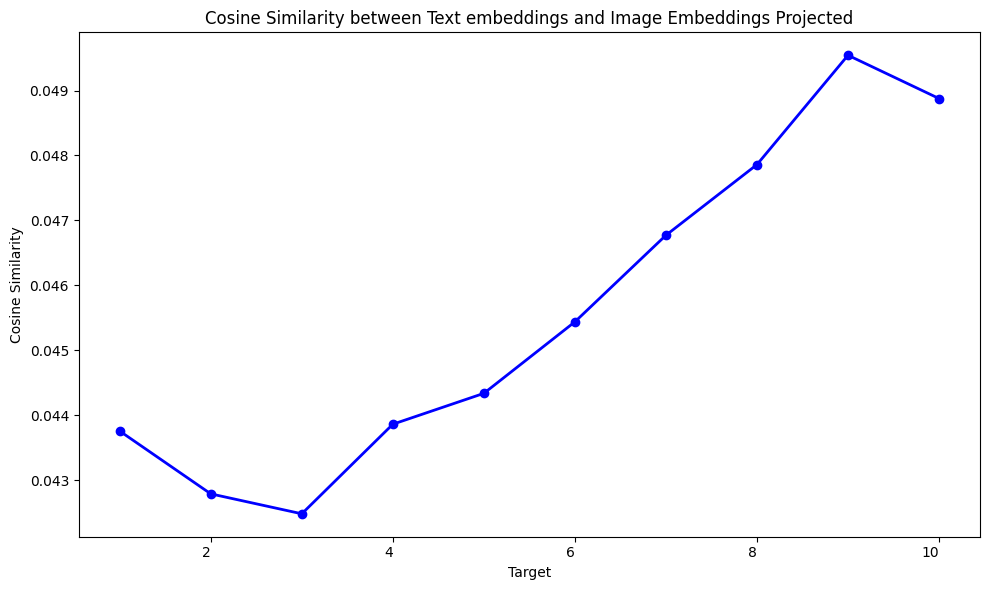

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the final_embeddings_vs_image_features_proj similarities for each target
targets = []
cosine_similarities_final_vs_image_proj = []

# Loop over the target_cosine_similarities dictionary and extract the needed values
for target, similarities in target_cosine_similarities.items():
    # Compute the average cosine similarity for the pair final_embeddings_vs_image_features_proj
    avg_sim_final_vs_image_proj = np.mean([sim[0] for sim in similarities])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    cosine_similarities_final_vs_image_proj.append(avg_sim_final_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_cosine_similarities = np.array(cosine_similarities_final_vs_image_proj)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_cosine_similarities, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Text embeddings and Image Embeddings Projected')
plt.xticks(rotation=0, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


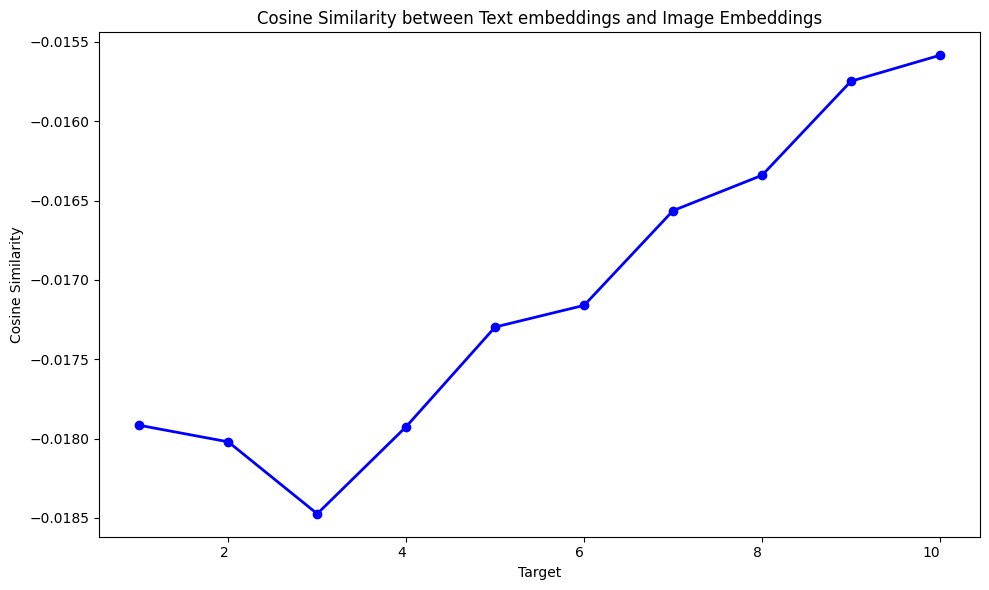

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the final_embeddings_vs_image_features_proj similarities for each target
targets = []
cosine_similarities_final_vs_image_proj = []

# Loop over the target_cosine_similarities dictionary and extract the needed values
for target, similarities in target_cosine_similarities.items():
    # Compute the average cosine similarity for the pair final_embeddings_vs_image_features_proj
    avg_sim_final_vs_image_proj = np.mean([sim[1] for sim in similarities])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    cosine_similarities_final_vs_image_proj.append(avg_sim_final_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_cosine_similarities = np.array(cosine_similarities_final_vs_image_proj)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_cosine_similarities, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Text embeddings and Image Embeddings')
plt.xticks(rotation=0, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


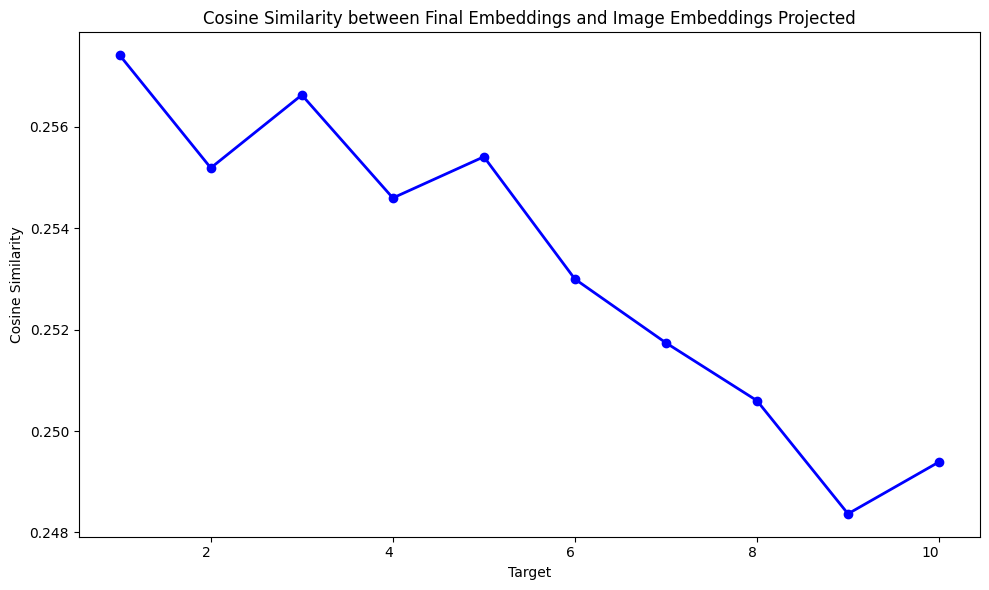

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the final_embeddings_vs_image_features_proj similarities for each target
targets = []
cosine_similarities_final_vs_image_proj = []

# Loop over the target_cosine_similarities dictionary and extract the needed values
for target, similarities in target_cosine_similarities.items():
    # Compute the average cosine similarity for the pair final_embeddings_vs_image_features_proj
    avg_sim_final_vs_image_proj = np.mean([sim[2] for sim in similarities])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    cosine_similarities_final_vs_image_proj.append(avg_sim_final_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_cosine_similarities = np.array(cosine_similarities_final_vs_image_proj)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_cosine_similarities, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Final Embeddings and Image Embeddings Projected')
plt.xticks(rotation=0, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


In [59]:
import numpy as np
from scipy.spatial.distance import euclidean

# Initialize a dictionary to store Euclidean distances for each target
target_euclidean_distances = {target: [] for target in set(item["target"] for item in model_answers)}

# Initialize the column names (feature pairs)
feature_pairs = [
    "image_features_proj_vs_text_features",
    "image_features_vs_reduced_features",
    "final_embeddings_vs_image_features_proj",
    "final_embeddings_vs_text_features",
    "final_embeddings_reduced_vs_image_features"
]

# Loop over the model_answers and compute Euclidean distance for each pair
for i, answer in enumerate(model_answers):
    target = answer["target"]
    
    # Extract corresponding features for this target
    text_feat = text_features[i]
    image_feat = image_features[i]
    image_feat_proj = image_features_proj[i]
    reduced_feat = reduced_features[i]  # assuming reduced_features is the same as image_features_proj for this example
    final_feat = final_embeddings[i]
    final_feat_reduced = final_embeddings_reduced[i]  # assuming final_embeddings_reduced is the same as final_embeddings for this example
    
    # Compute Euclidean distances between all pairs
    eucl_dist_image_proj_vs_text = euclidean(image_feat_proj, text_feat)
    eucl_dist_image_vs_reduced = euclidean(image_feat, reduced_feat)
    eucl_dist_final_vs_image_proj = euclidean(final_feat, image_feat_proj)
    eucl_dist_final_vs_text = euclidean(final_feat, text_feat)
    eucl_dist_final_reduced_vs_image = euclidean(final_feat_reduced, image_feat)
    
    # Append the distances to the corresponding target's entry
    target_euclidean_distances[target].append([
        eucl_dist_image_proj_vs_text,
        eucl_dist_image_vs_reduced,
        eucl_dist_final_vs_image_proj,
        eucl_dist_final_vs_text,
        eucl_dist_final_reduced_vs_image
    ])

# Print out the table
# First, print the header row (VS pairs)
print(f"{'Target':<10} {'image_features_proj_vs_text_features':<30} {'image_features_vs_reduced_features':<30} {'final_embeddings_vs_image_features_proj':<40} {'final_embeddings_vs_text_features':<40} {'final_embeddings_reduced_vs_image_features':<40}")

# Then, for each target, print the Euclidean distances for each pair
for target, distances in target_euclidean_distances.items():
    # Compute the average Euclidean distance for each pair for the given target
    avg_distances = np.mean(distances, axis=0)
    print(f"{target:<10} {avg_distances[0]:<30.4f} {avg_distances[1]:<30.4f} {avg_distances[2]:<40.4f} {avg_distances[3]:<40.4f} {avg_distances[4]:<40.4f}")


Target     image_features_proj_vs_text_features image_features_vs_reduced_features final_embeddings_vs_image_features_proj  final_embeddings_vs_text_features        final_embeddings_reduced_vs_image_features
1          1.3829                         61.0983                        1.2186                                   1.3713                                   7.2144                                  
2          1.3836                         61.0984                        1.2205                                   1.3710                                   7.1261                                  
3          1.3838                         61.0988                        1.2193                                   1.3712                                   7.0528                                  
4          1.3828                         61.0983                        1.2210                                   1.3708                                   7.0636                                  
5       

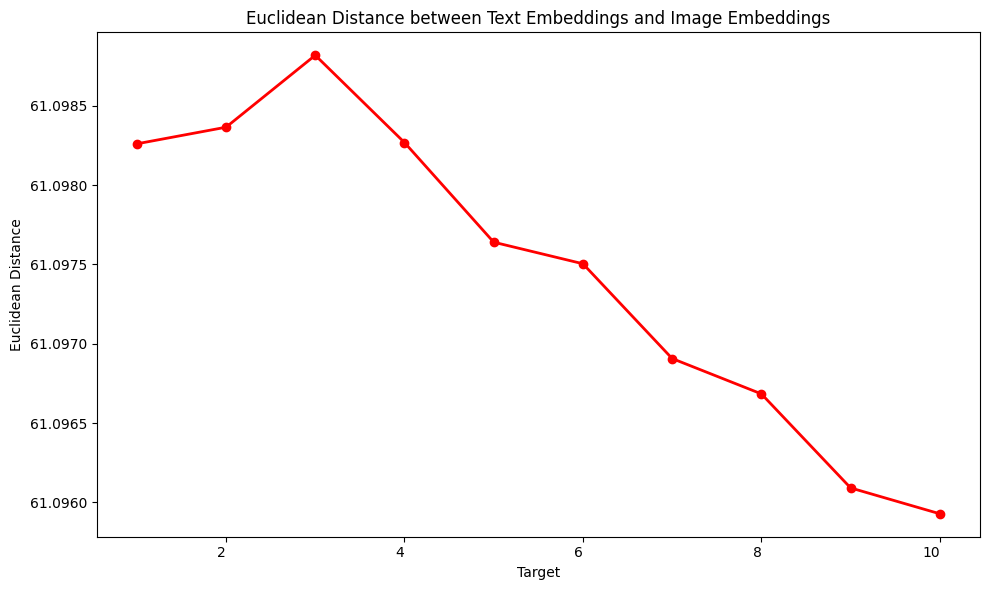

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean

# Extract the Euclidean distances for final_embeddings_vs_image_features_proj for each target
targets = []
euclidean_distances_text_vs_image = []

# Loop over the target_euclidean_distances dictionary and extract the needed values
for target, distances in target_euclidean_distances.items():
    # Compute the average Euclidean distance for the pair final_embeddings_vs_image_features_proj
    avg_dist_text_vs_image_proj = np.mean([dist[1] for dist in distances])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    euclidean_distances_text_vs_image.append(avg_dist_text_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_euclidean_distances = np.array(euclidean_distances_text_vs_image)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_euclidean_distances, marker='o', color='r', linestyle='-', linewidth=2, markersize=6)

import matplotlib.ticker as mticker

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance between Text Embeddings and Image Embeddings')
plt.xticks(rotation=0, ha='right')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.4f}"))  # Display with 4 decimal places
# Display the plot
plt.tight_layout()
plt.show()




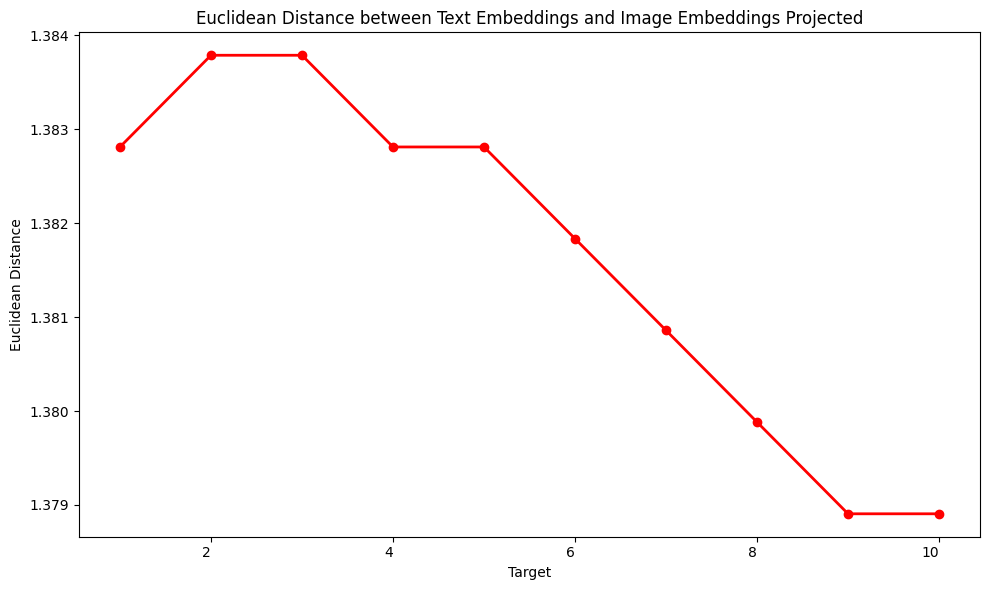

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean

# Extract the Euclidean distances for final_embeddings_vs_image_features_proj for each target
targets = []
euclidean_distances_text_vs_image_proj = []

# Loop over the target_euclidean_distances dictionary and extract the needed values
for target, distances in target_euclidean_distances.items():
    # Compute the average Euclidean distance for the pair final_embeddings_vs_image_features_proj
    avg_dist_text_vs_image_proj = np.mean([dist[0] for dist in distances])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    euclidean_distances_text_vs_image_proj.append(avg_dist_text_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_euclidean_distances = np.array(euclidean_distances_text_vs_image_proj)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_euclidean_distances, marker='o', color='r', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance between Text Embeddings and Image Embeddings Projected')
plt.xticks(rotation=0, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


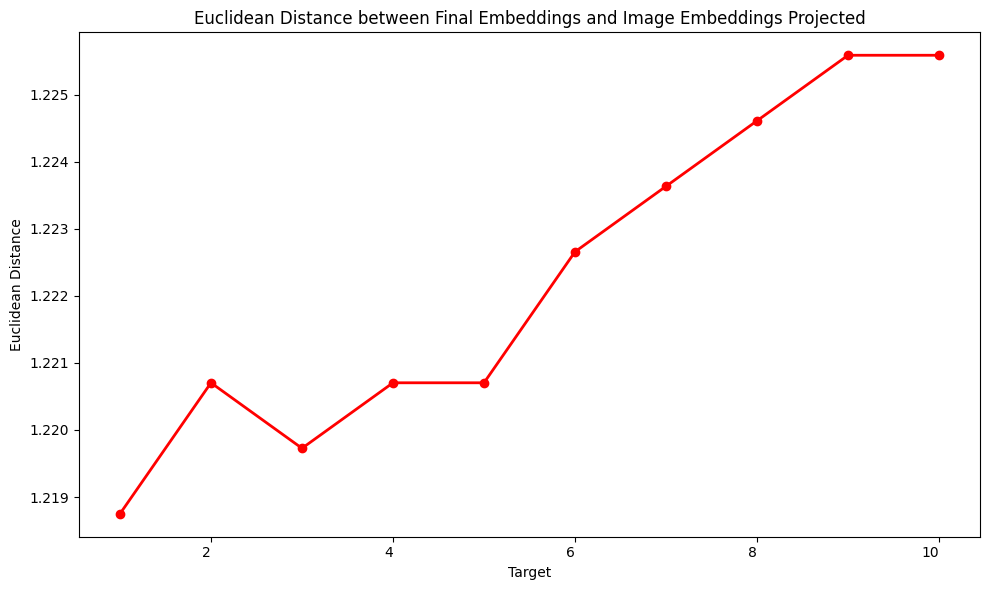

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean

# Extract the Euclidean distances for final_embeddings_vs_image_features_proj for each target
targets = []
euclidean_distances_final_vs_image_proj = []

# Loop over the target_euclidean_distances dictionary and extract the needed values
for target, distances in target_euclidean_distances.items():
    # Compute the average Euclidean distance for the pair final_embeddings_vs_image_features_proj
    avg_dist_final_vs_image_proj = np.mean([dist[2] for dist in distances])  # index 2 corresponds to final_embeddings_vs_image_features_proj
    targets.append(target)
    euclidean_distances_final_vs_image_proj.append(avg_dist_final_vs_image_proj)

# Sort targets for consistency in plotting
sorted_targets = np.array(targets)
sorted_euclidean_distances = np.array(euclidean_distances_final_vs_image_proj)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_targets, sorted_euclidean_distances, marker='o', color='r', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance between Final Embeddings and Image Embeddings Projected')
plt.xticks(rotation=0, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import time
from scipy.spatial import ConvexHull

# Assuming image_features_proj and text_features are defined, as well as apple_files

data = np.concatenate([image_features_proj, final_embeddings], 0)

# Run t-SNE on data
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=2000, random_state=42)
embedding_tsne = tsne.fit_transform(data)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))





c:\Users\matti\Documents\GitHub\Modality-Gap\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.011s...
[t-SNE] Computed neighbors for 5000 samples in 1.614s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.029720
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.623535
[t-SNE] KL divergence after 2000 iterations: 0.493900
t-SNE done! Time elapsed: 34.95949625968933 seconds


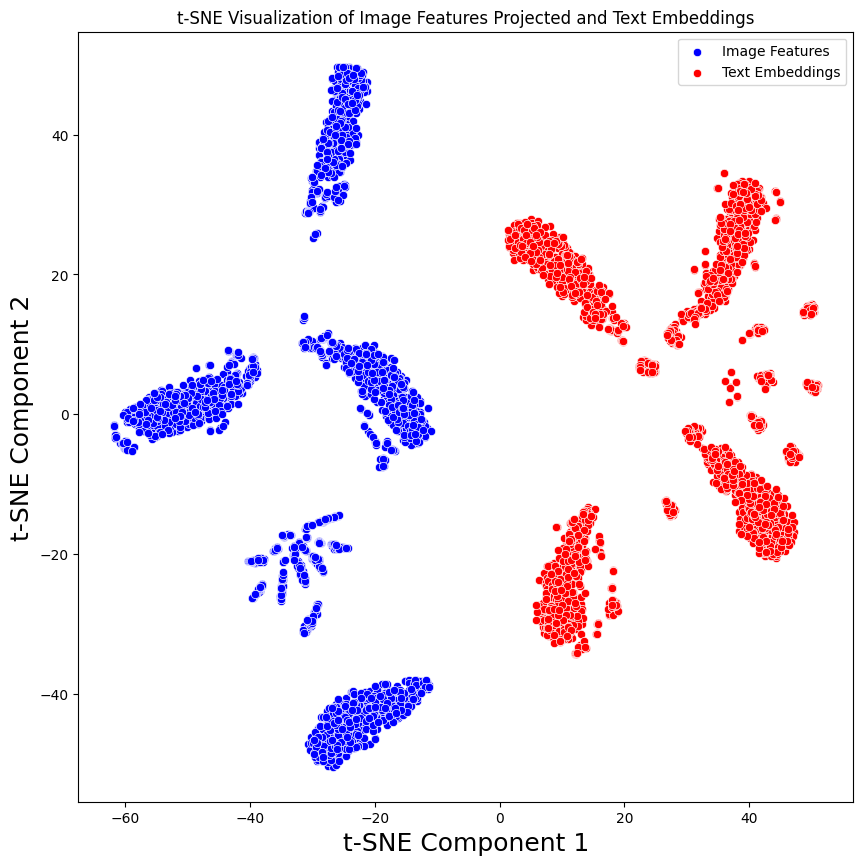

In [80]:
# Plot t-SNE
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embedding_tsne[:len(image_features_proj), 0], 
                y=embedding_tsne[:len(image_features_proj), 1], 
                color='blue', label='Image Features')
sns.scatterplot(x=embedding_tsne[len(image_features_proj):, 0],
                y=embedding_tsne[len(image_features_proj):, 1],
                color='red', label='Text Embeddings')
plt.title('t-SNE Visualization of Image Features Projected and Text Embeddings')
plt.xlabel('t-SNE Component 1', fontsize=18)
plt.ylabel('t-SNE Component 2', fontsize=18)
plt.legend()
plt.show()

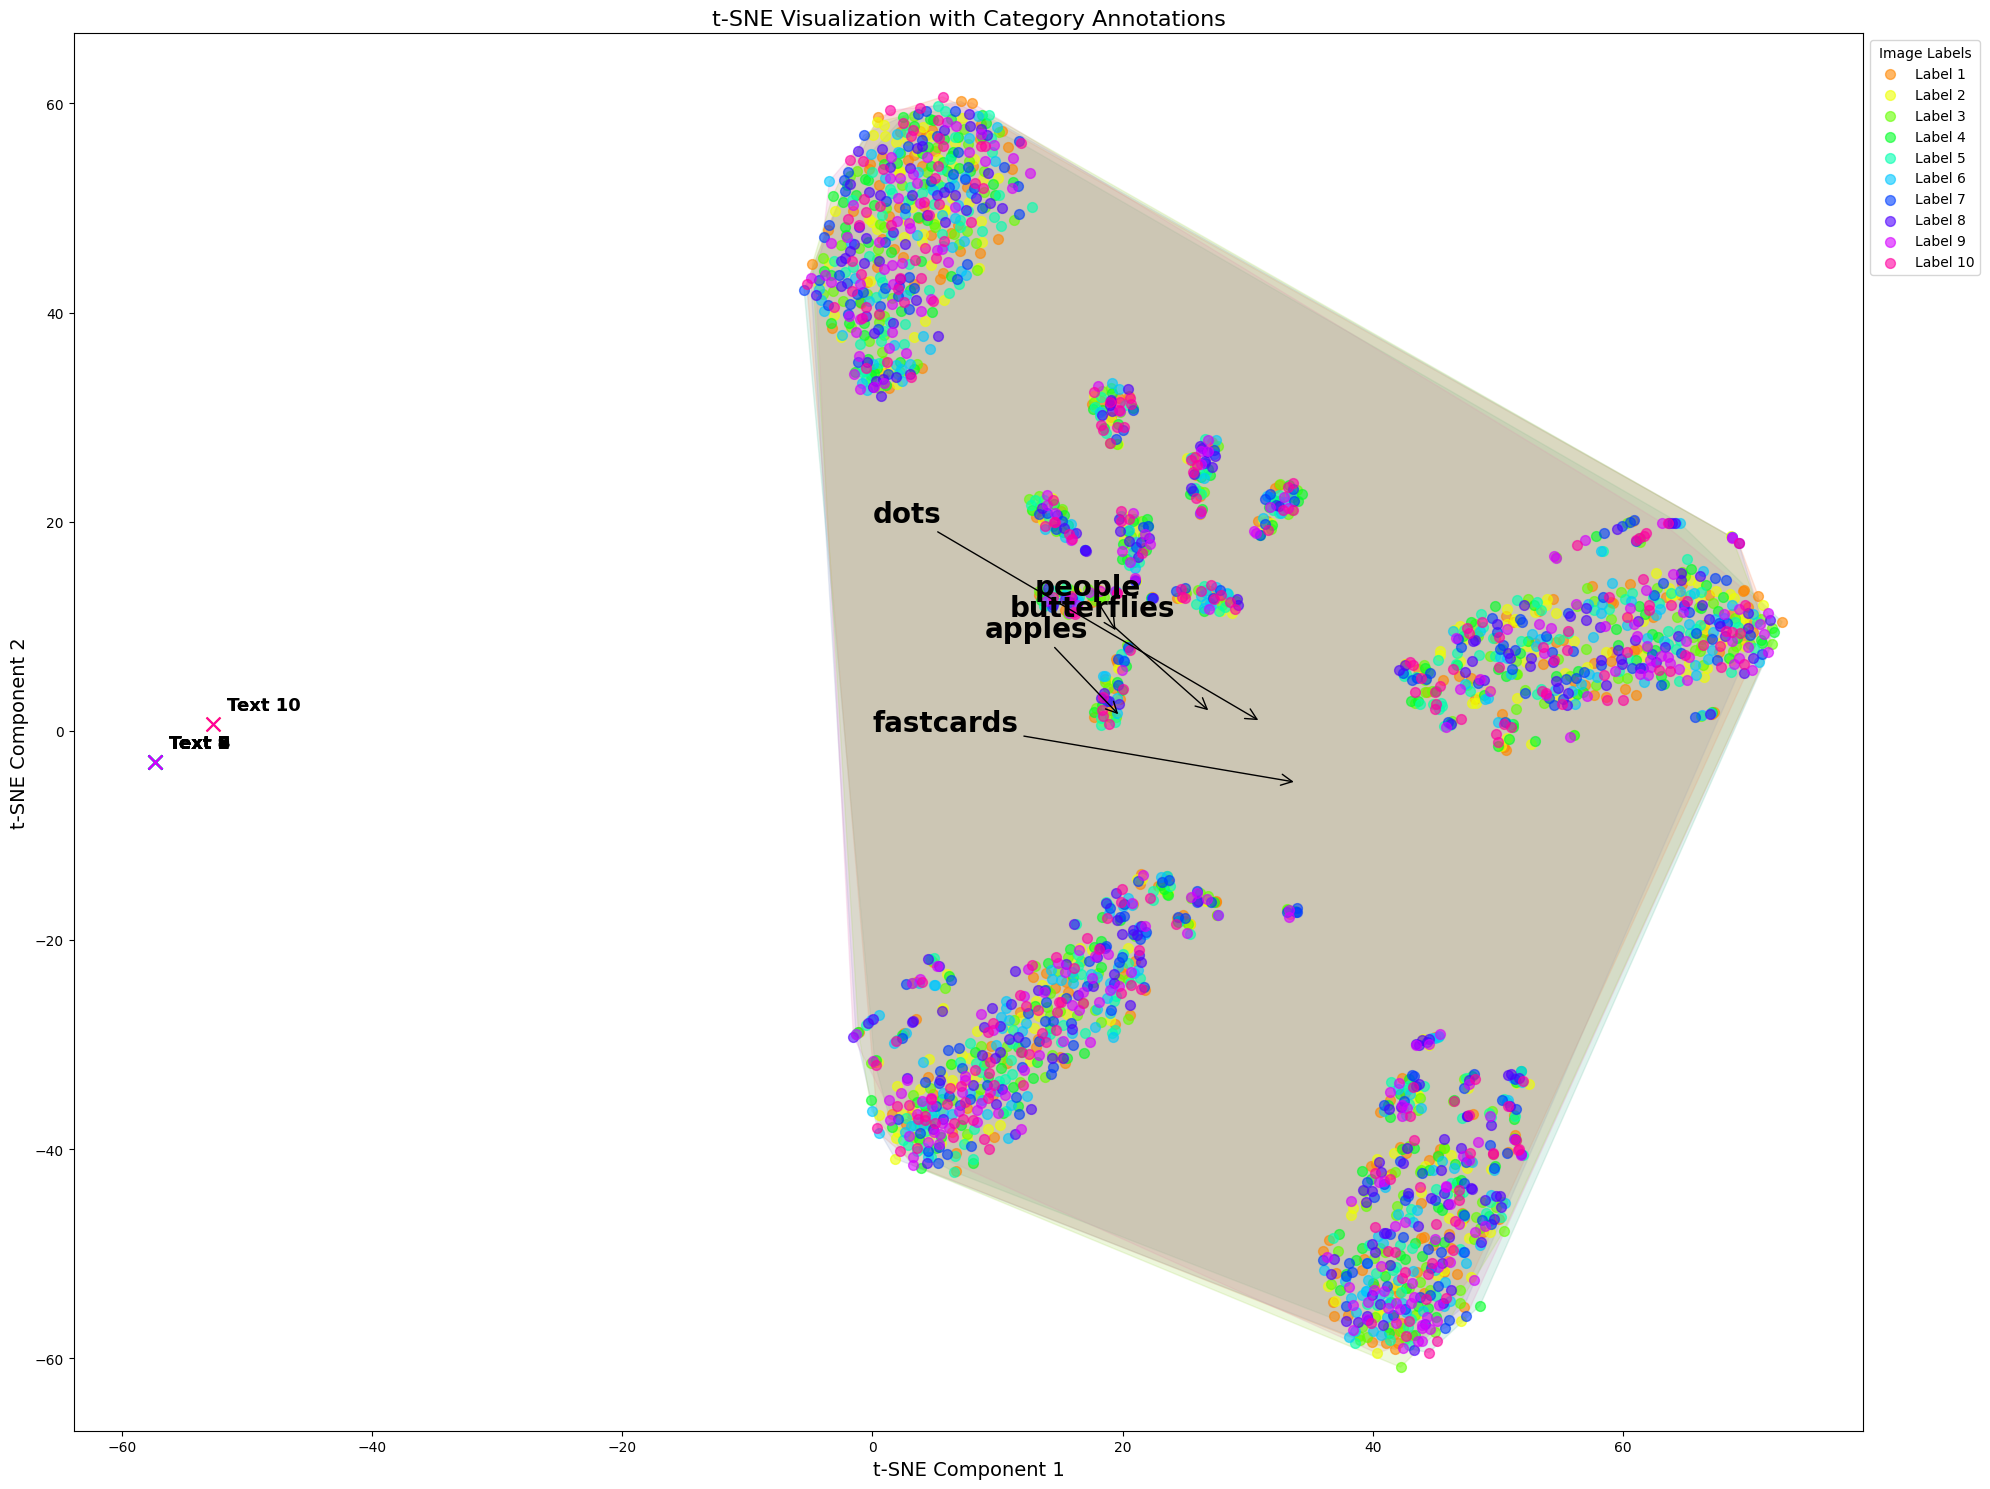

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels and categories from filenames
image_labels = [int(filename.split('_')[0]) for filename in image_list]
image_categories = [filename.split('_')[1] for filename in image_list]
text_labels = [int(filename.split('_')[0]) for filename in image_list]
text_categories = [filename.split('_')[1] for filename in image_list]

# Get unique labels and categories
unique_labels = np.unique(image_labels)
unique_categories = np.unique(image_categories)

# Create color maps
image_colors = sns.color_palette("hsv", len(unique_labels))
category_colors = sns.color_palette("Set2", len(unique_categories))

# Create figure
plt.figure(figsize=(20, 15))

# Manually defined annotation positions (you can modify these)
category_positions = {
    'apples': (9, 9),   # example x, y coordinates
    'butterflies': (11, 11),  # modify these as needed
    'people': (13, 13),
    'dots': (0, 20),
    'fastcards': (0, 0)
}

# Loop through each unique category
for cat_idx, category in enumerate(unique_categories):
    # Get indices of images with current category
    category_indices = [i for i, cat in enumerate(image_categories) if cat == category]
    
    # Get the image embeddings for current category
    current_category_embeddings = embedding_tsne[category_indices]
    
    # Create convex hull if we have enough points
    if len(current_category_embeddings) >= 3:
        # Calculate convex hull
        hull = ConvexHull(current_category_embeddings)
        
        # Plot convex hull
        plt.fill(current_category_embeddings[hull.vertices, 0], 
                current_category_embeddings[hull.vertices, 1], 
                color=category_colors[cat_idx], alpha=0.2)
        
        # Calculate centroid of the hull
        centroid = np.mean(current_category_embeddings[hull.vertices], axis=0)
        
        # Check if category has a predefined position
        if category in category_positions:
            annotation_pos = category_positions[category]
            
            # Annotate category with custom position
            plt.annotate(category, 
                         xy=centroid,  # Point to category's centroid
                         xytext=annotation_pos,  # Place text at specified position
                         color='black',
                         fontweight='bold',
                         fontsize=20,  # Increased font size
                         arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot image points with original label colors
scatter_handles = []
scatter_labels = []

for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[image_indices]
    
    # Plot the image points with original colors
    scatter = plt.scatter(current_image_embeddings[:, 0], 
               current_image_embeddings[:, 1], 
               c=[image_colors[idx]], s=50, alpha=0.6)
    scatter_handles.append(scatter)
    scatter_labels.append(f'Label {label}')
    
    # Get the corresponding text embedding
    # Text embeddings start after all image embeddings
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Plot text point with the same color as the image label
    plt.scatter(text_embedding[0], text_embedding[1], 
               c=[image_colors[idx]], marker='x', s=100)
    
    # Add annotation for text point directly on the point
    plt.annotate(f'Text {label}', 
                 xy=(text_embedding[0], text_embedding[1]), 
                 xytext=(10,10),  # Slight offset to avoid overlapping
                 textcoords='offset points',
                 fontsize=13,
                 color='black',
                 fontweight='bold')

    # Draw an arrow from the text point to the centroid of the image category
    #centroid = np.mean(current_image_embeddings, axis=0)  # Centroid of the image category
    #plt.annotate('', 
    #             xy=(centroid[0], centroid[1]), 
    #             xytext=(text_embedding[0], text_embedding[1]), 
    #             arrowprops=dict(arrowstyle='->', color=image_colors[idx], lw=1))

# Add title and labels
plt.title('t-SNE Visualization with Category Annotations', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Create legend for image labels
plt.legend(scatter_handles, scatter_labels, loc='upper left', title='Image Labels', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
#savefig

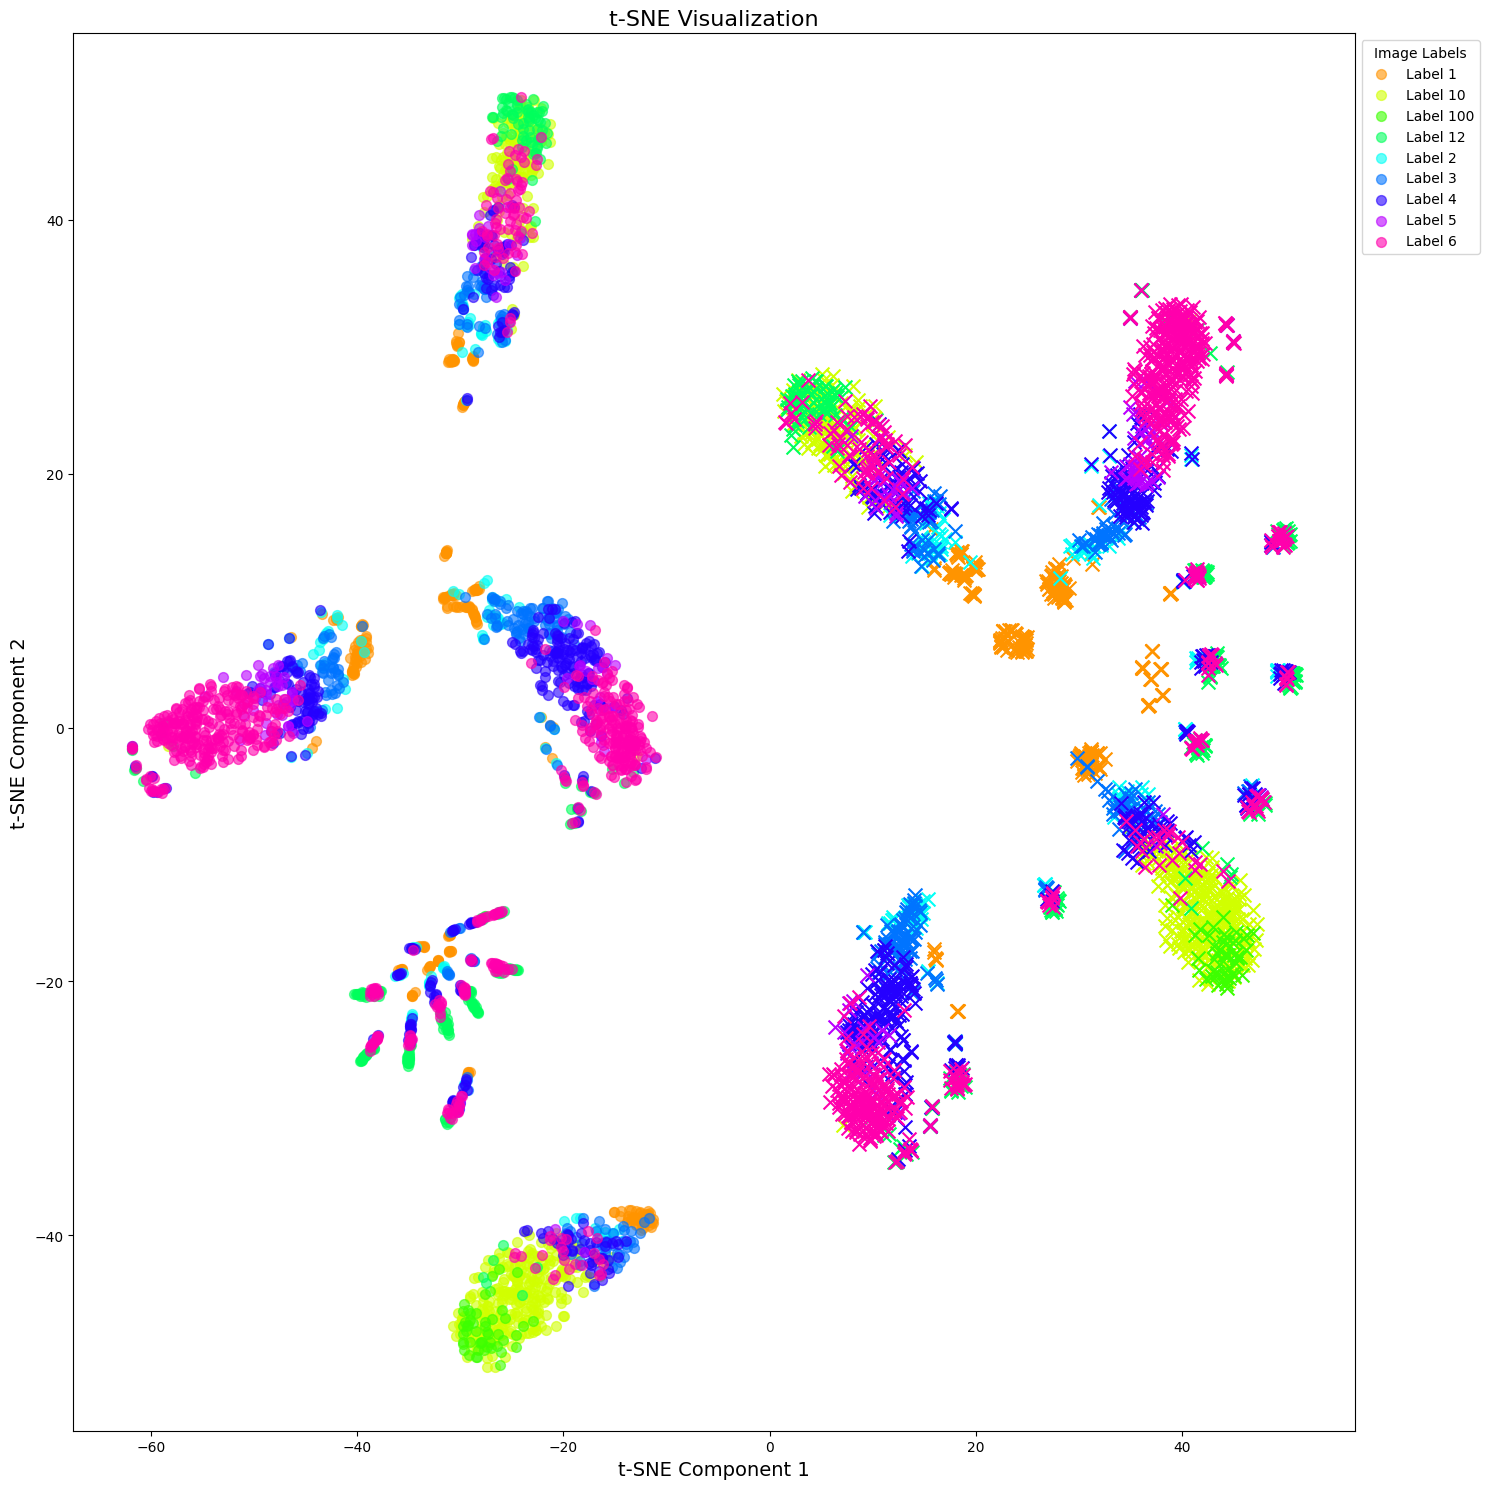

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get number of images 
n_images = len(image_features_proj)

# Create labels and categories from filenames
#image_labels = [int(filename.split('_')[0]) for filename in image_list]
image_labels = [model_answers[i]['predicted_number'] for i in range(len(image_list))]
image_categories = [filename.split('_')[1] for filename in image_list]
#final_embeddings_labels = [int(filename.split('_')[0]) for filename in image_list]
final_embeddings_labels = [model_answers[i]['predicted_number'] for i in range(len(image_list))]
final_embeddings_categories = [filename.split('_')[1] for filename in image_list]

# Get unique labels and categories
unique_labels = np.unique(image_labels)
unique_categories = np.unique(image_categories)

# Create color maps
image_colors = sns.color_palette("hsv", len(unique_labels))
category_colors = sns.color_palette("Set2", len(unique_categories))

# Create figure
plt.figure(figsize=(15, 15))

# Plot image points with original label colors
scatter_handles = []
scatter_labels = []

# Plot image features
for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[:n_images][image_indices]
    
    # Plot the image points with original colors
    scatter = plt.scatter(current_image_embeddings[:, 0], 
               current_image_embeddings[:, 1], 
               c=[image_colors[idx]], s=50, alpha=0.6, label=f'Label {label}')
    scatter_handles.append(scatter)
    scatter_labels.append(f'Label {label}')

# Plot final embeddings
for idx, label in enumerate(unique_labels):
    # Plot final embeddings with the same color as corresponding image label
    final_embedding_indices = [i for i, emb_label in enumerate(final_embeddings_labels) if emb_label == label]
    
    # Get the final embeddings for current label
    current_final_embeddings = embedding_tsne[n_images:][final_embedding_indices]
    
    plt.scatter(current_final_embeddings[:, 0], 
                current_final_embeddings[:, 1], 
                c=[image_colors[idx]], marker='x', s=100)

# Add title and labels
plt.title('t-SNE Visualization', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Create legend for image labels
plt.legend(scatter_handles, scatter_labels, loc='upper left', title='Image Labels', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

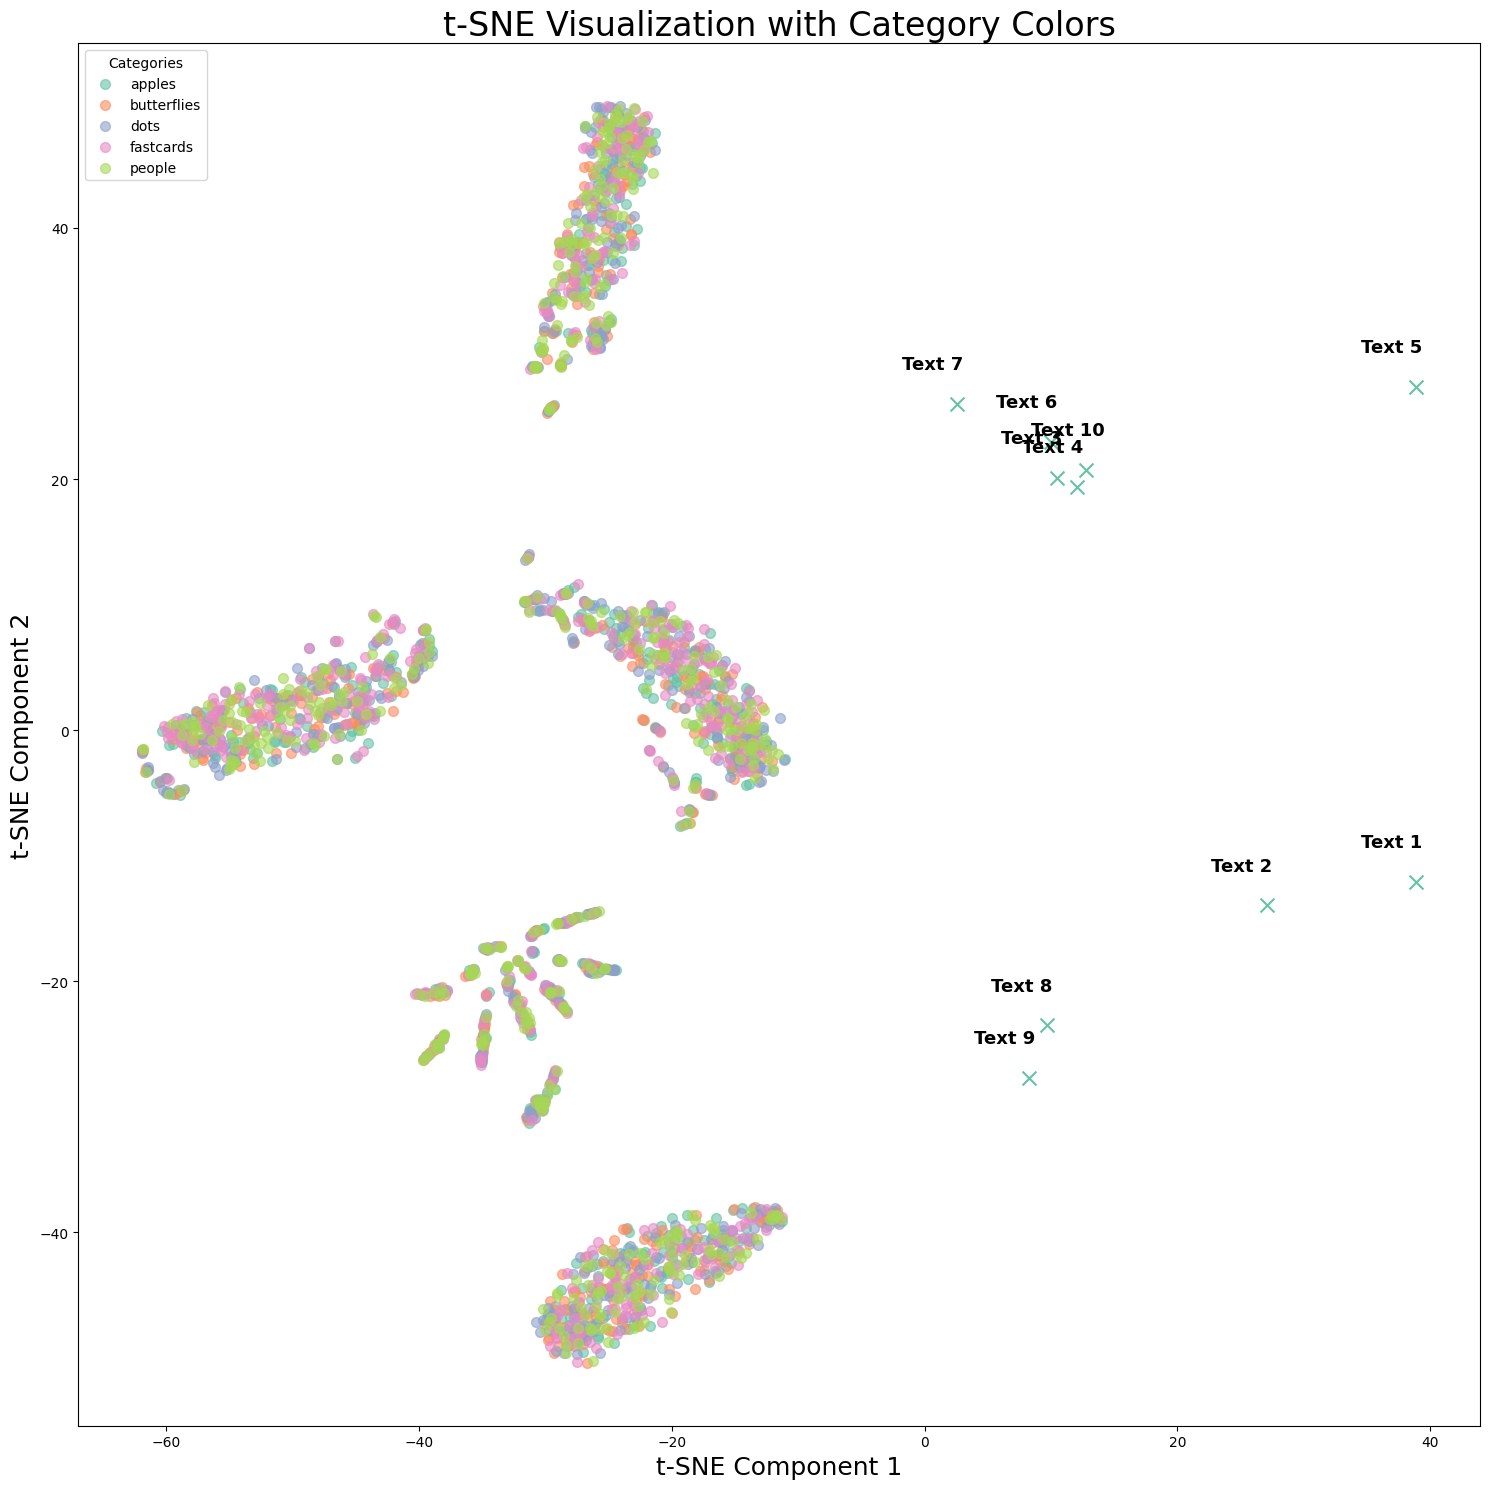

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels and categories from filenames
image_labels = [int(filename.split('_')[0]) for filename in image_list]
image_categories = [filename.split('_')[1] for filename in image_list]
text_labels = [int(filename.split('_')[0]) for filename in image_list]
text_categories = [filename.split('_')[1] for filename in image_list]

# Get unique labels and categories
unique_labels = np.unique(image_labels)
unique_categories = np.unique(image_categories)

# Create color maps for categories
category_colors = sns.color_palette("Set2", len(unique_categories))
category_color_map = {category: category_colors[idx] for idx, category in enumerate(unique_categories)}

# Create figure
plt.figure(figsize=(15, 15))

# Loop through each unique category
scatter_handles = []
scatter_labels = []

for cat_idx, category in enumerate(unique_categories):
    # Get indices of images with current category
    category_indices = [i for i, cat in enumerate(image_categories) if cat == category]
    
    # Get the image embeddings for current category
    current_category_embeddings = embedding_tsne[category_indices]
    
    # Plot image points with category colors
    scatter = plt.scatter(current_category_embeddings[:, 0], 
                           current_category_embeddings[:, 1], 
                           c=[category_colors[cat_idx]], 
                           s=50, alpha=0.6, label=category)
    scatter_handles.append(scatter)
    scatter_labels.append(category)

# Plot text points
for idx, label in enumerate(unique_labels):
    # Get the corresponding text embedding
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Use the color of the text's category for consistency
    text_category = text_categories[text_index - n_images]
    text_color = category_color_map[text_category]
    
    # Plot text point with the same color as the category
    plt.scatter(text_embedding[0], text_embedding[1], 
                c=[text_color], marker='x', s=100)
    
    # Add annotation for text point slightly offset
    plt.annotate(f'Text {label}', 
                 xy=(text_embedding[0], text_embedding[1]), 
                 xytext=(-40, 25),  # Slight offset for visibility
                 textcoords='offset points',
                 fontsize=13,
                 color='black',
                 fontweight='bold')

# Add title and labels
plt.title('t-SNE Visualization with Category Colors', fontsize=24)
plt.xlabel('t-SNE Component 1', fontsize=18)
plt.ylabel('t-SNE Component 2', fontsize=18)

# Add legend for categories
plt.legend(scatter_handles, scatter_labels, loc='upper left', title='Categories')

plt.tight_layout()
plt.show()


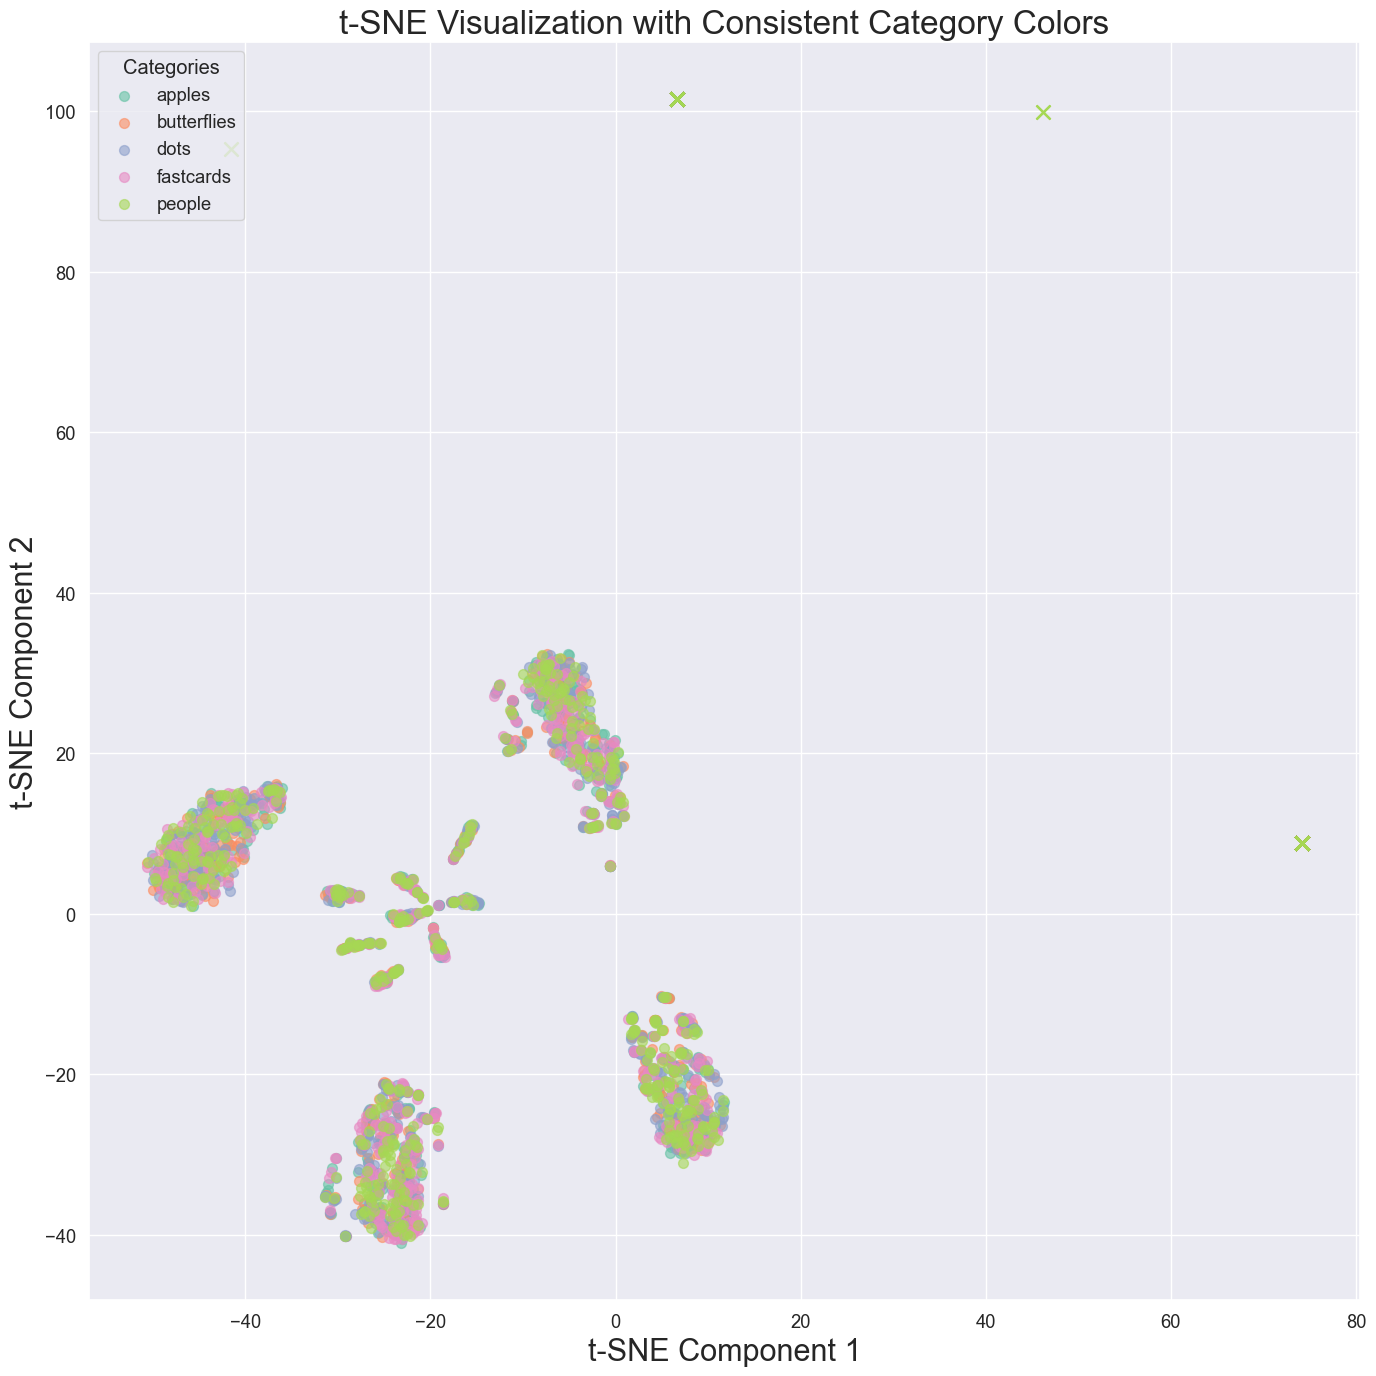

In [ ]:
# Get number of images and texts
n_images = len(image_features_proj)
n_texts = len(final_embeddings)

# Create labels and categories from filenames
# Assume image_list and text_list are available with the same naming convention
image_labels = [int(filename.split('_')[0]) for filename in image_list]
image_categories = [filename.split('_')[1] for filename in image_list]
text_labels = [int(filename.split('_')[0]) for filename in image_list]
text_categories = [filename.split('_')[1] for filename in image_list]

# Get unique categories
unique_categories = np.unique(np.concatenate([image_categories, text_categories]))

# Create color maps for categories
category_colors = sns.color_palette("Set2", len(unique_categories))
category_color_map = {category: category_colors[idx] for idx, category in enumerate(unique_categories)}

# Create figure
plt.figure(figsize=(14, 14))

# Plot image points
scatter_handles = []
scatter_labels = []

for cat_idx, category in enumerate(unique_categories):
    # Get indices of images with current category
    category_indices = [i for i, cat in enumerate(image_categories) if cat == category]
    
    # Get the image embeddings for current category
    current_category_embeddings = embedding_tsne[:n_images][category_indices]
    
    # Plot image points with category colors
    scatter = plt.scatter(current_category_embeddings[:, 0], 
                          current_category_embeddings[:, 1], 
                          c=[category_colors[cat_idx]], 
                          s=50, alpha=0.6, label=category)
    scatter_handles.append(scatter)
    scatter_labels.append(category)

# Plot text points
for cat_idx, category in enumerate(unique_categories):
    # Get indices of texts with current category
    category_indices = [i for i, cat in enumerate(text_categories) if cat == category]
    
    # Get the text embeddings for current category
    current_category_embeddings = embedding_tsne[n_images:][category_indices]
    
    # Plot text points with category colors (using 'x' marker)
    plt.scatter(current_category_embeddings[:, 0], 
                current_category_embeddings[:, 1], 
                c=[category_colors[cat_idx]], 
                marker='x', s=100, alpha=0.8)



# Add title and labels
plt.title('t-SNE Visualization with Consistent Category Colors', fontsize=24)
plt.xlabel('t-SNE Component 1', fontsize=22, )
plt.ylabel('t-SNE Component 2', fontsize=22)

# Add legend for categories
plt.legend(scatter_handles, scatter_labels, loc='upper left', title='Categories')

plt.tight_layout()
plt.show()

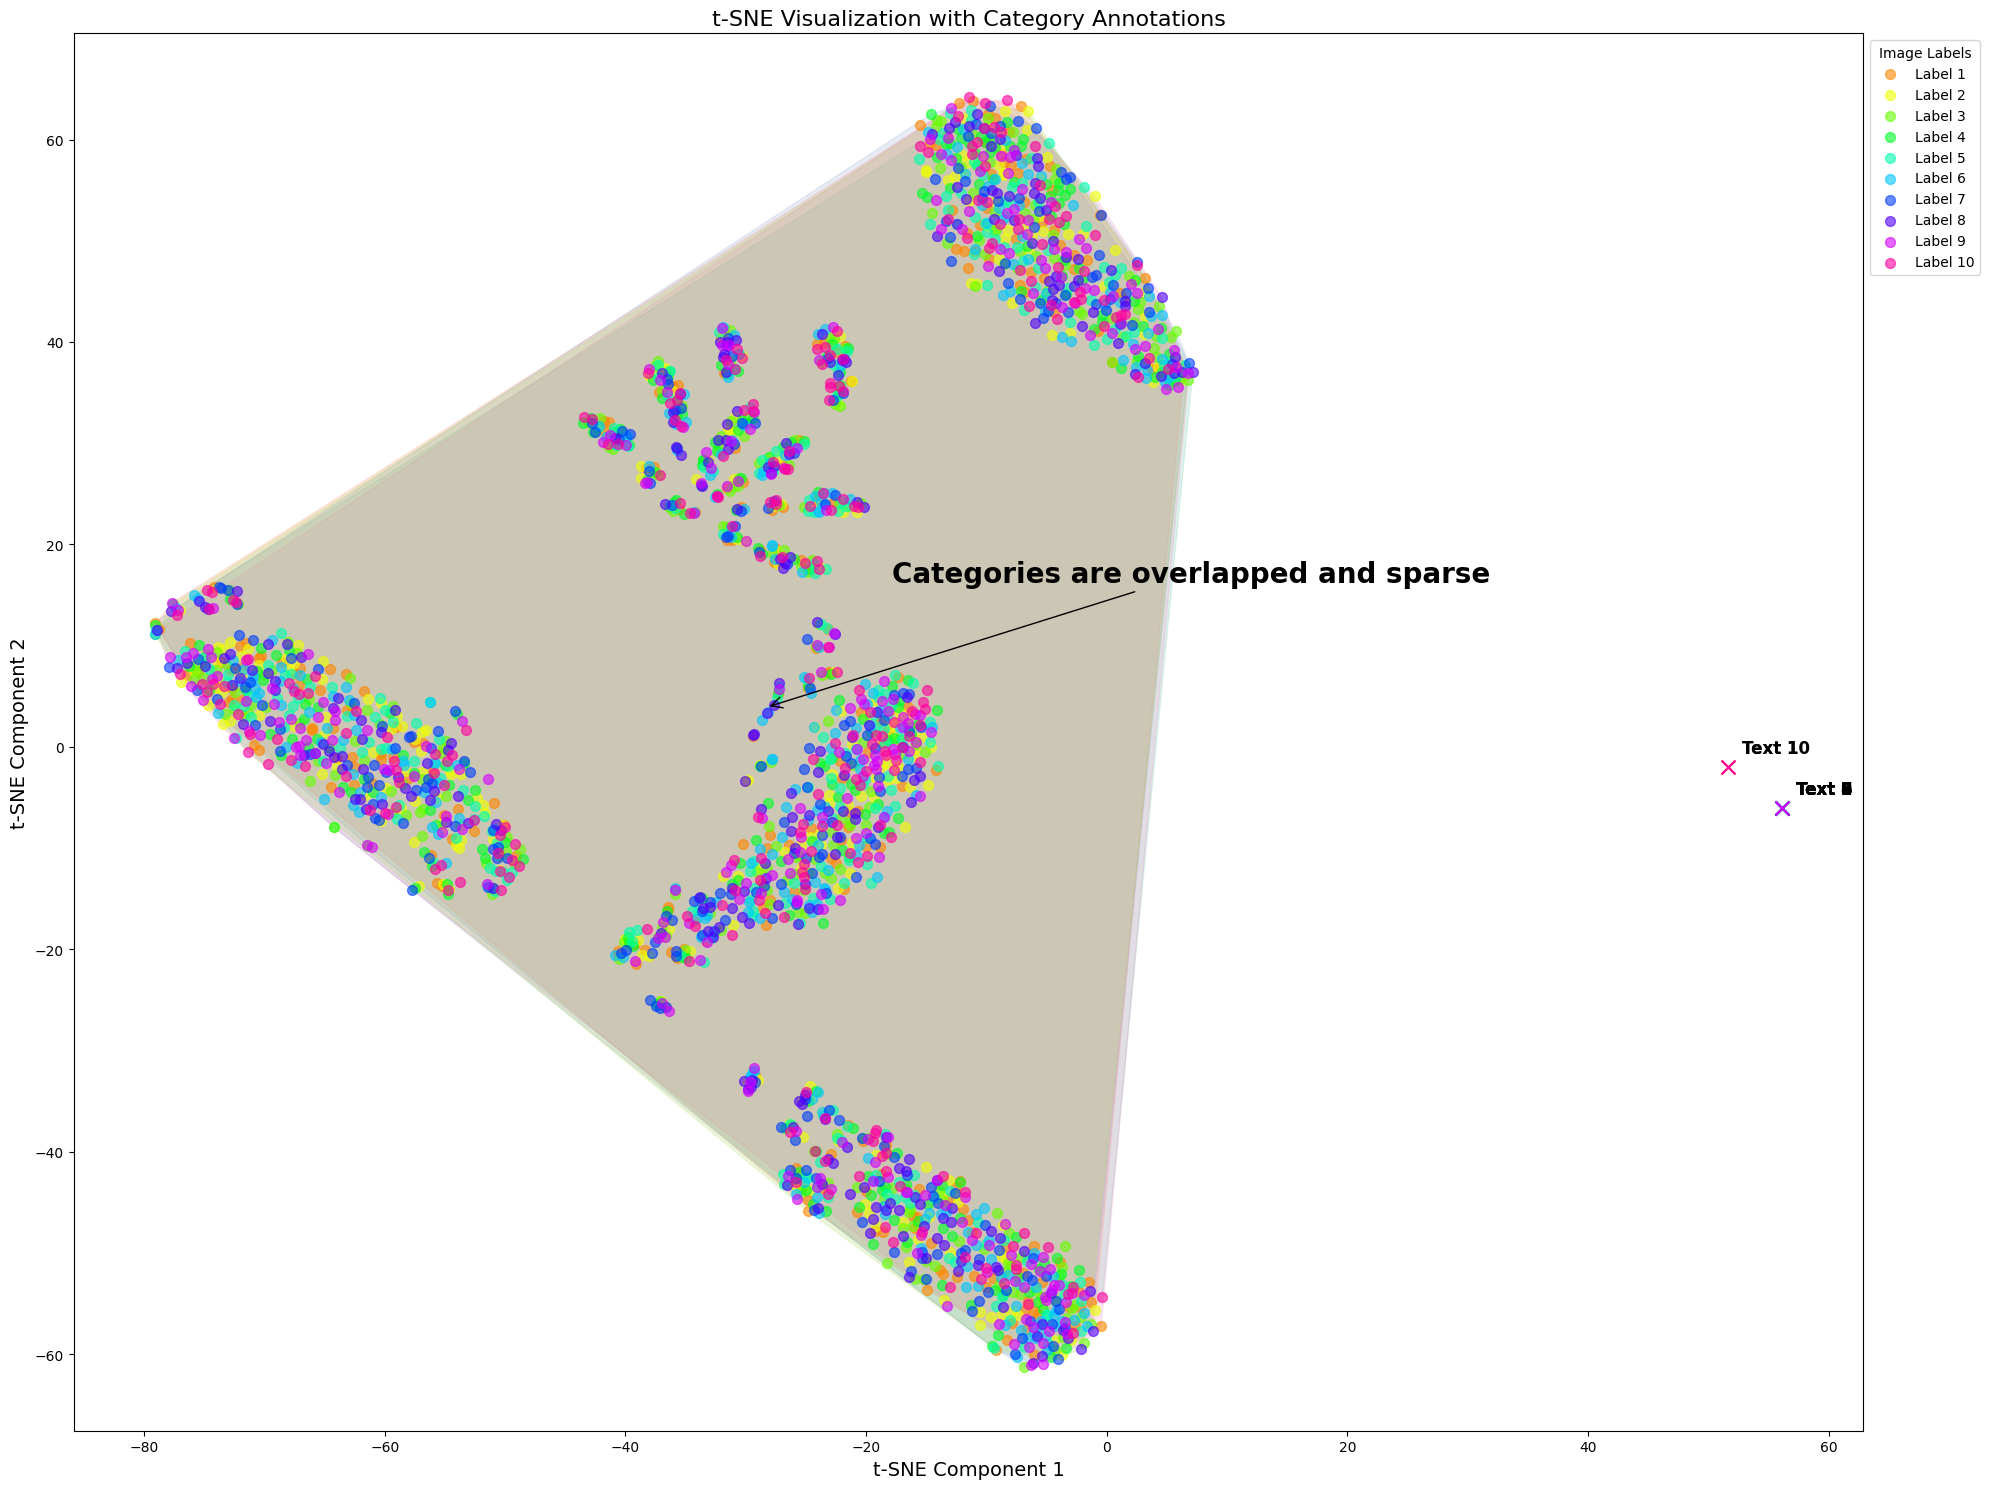

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels and categories from filenames
image_labels = [int(filename.split('_')[0]) for filename in image_list]
image_categories = [filename.split('_')[1] for filename in image_list]
text_labels = [int(filename.split('_')[0]) for filename in image_list]
text_categories = [filename.split('_')[1] for filename in image_list]

# Get unique labels and categories
unique_labels = np.unique(image_labels)
unique_categories = np.unique(image_categories)

# Create color maps
image_colors = sns.color_palette("hsv", len(unique_labels))
category_colors = sns.color_palette("Set2", len(unique_categories))

# Create figure
plt.figure(figsize=(20, 15))

# Initialize list to collect all embeddings for category-based centroid
all_embeddings = []

# Loop through each unique category
for cat_idx, category in enumerate(unique_categories):
    # Get indices of images with current category
    category_indices = [i for i, cat in enumerate(image_categories) if cat == category]
    
    # Get the image embeddings for current category
    current_category_embeddings = embedding_tsne[category_indices]
    
    # Collect all category embeddings for centroid calculation
    all_embeddings.extend(current_category_embeddings)

    # Create convex hull if we have enough points
    if len(current_category_embeddings) >= 3:
        # Calculate convex hull
        hull = ConvexHull(current_category_embeddings)
        
        # Plot convex hull
        plt.fill(current_category_embeddings[hull.vertices, 0], 
                current_category_embeddings[hull.vertices, 1], 
                color=category_colors[cat_idx], alpha=0.2)

# Compute the centroid of all the points (average position)
all_embeddings = np.array(all_embeddings)
overall_centroid = np.mean(all_embeddings, axis=0)

# Add annotation for the overall centroid with an arrow pointing to the center
plt.annotate('Categories are overlapped and sparse', 
             xy=overall_centroid,  # Point to the overall centroid
             xytext=(+90, +90),  # Offset to avoid overlapping
             textcoords='offset points',
             fontsize=20,
             color='black',
             fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot image points with original label colors
scatter_handles = []
scatter_labels = []

for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[image_indices]
    
    # Plot the image points with original colors
    scatter = plt.scatter(current_image_embeddings[:, 0], 
               current_image_embeddings[:, 1], 
               c=[image_colors[idx]], s=50, alpha=0.6)
    scatter_handles.append(scatter)
    scatter_labels.append(f'Label {label}')
    
    # Get the corresponding text embedding
    # Text embeddings start after all image embeddings
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Plot text point with the same color as the image label
    plt.scatter(text_embedding[0], text_embedding[1], 
               c=[image_colors[idx]], marker='x', s=100)
    
    # Add annotation for text point directly on the point
    plt.annotate(f'Text {label}', 
                 xy=(text_embedding[0], text_embedding[1]), 
                 xytext=(10,10),  # Slight offset to avoid overlapping
                 textcoords='offset points',
                 fontsize=12,
                 color='black',
                 fontweight='bold')

# Add title and labels
plt.title('t-SNE Visualization with Category Annotations', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Create legend for image labels
plt.legend(scatter_handles, scatter_labels, loc='upper left', title='Image Labels', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


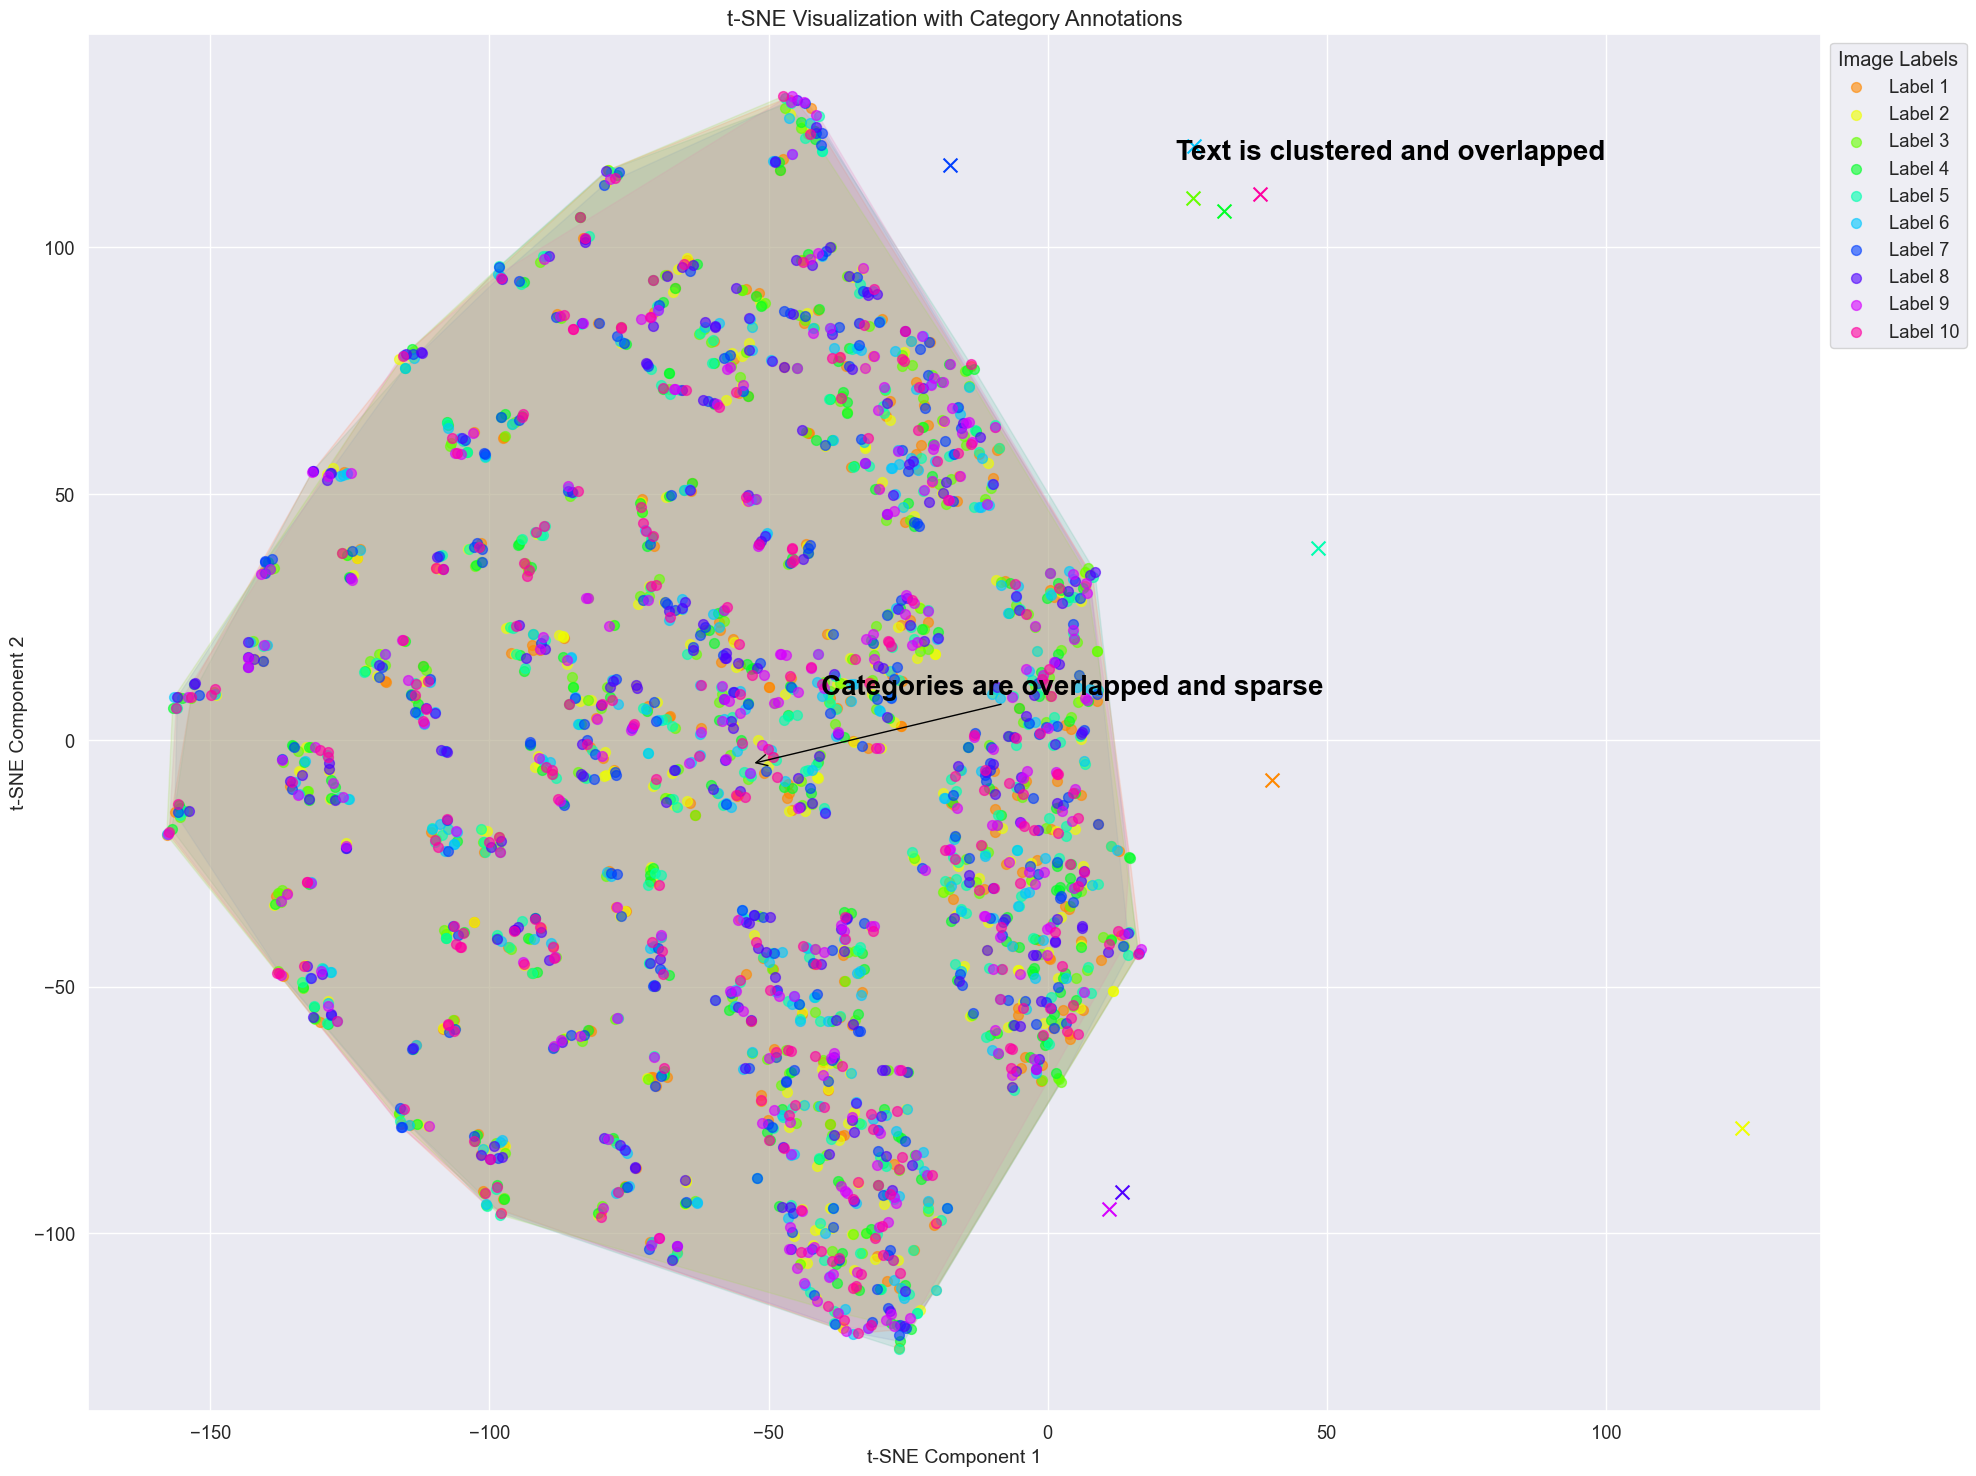

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels and categories from filenames
image_labels = [int(filename.split('_')[0]) for filename in image_list]
image_categories = [filename.split('_')[1] for filename in image_list]
text_labels = [int(filename.split('_')[0]) for filename in image_list]
text_categories = [filename.split('_')[1] for filename in image_list]

# Get unique labels and categories
unique_labels = np.unique(image_labels)
unique_categories = np.unique(image_categories)

# Create color maps
image_colors = sns.color_palette("hsv", len(unique_labels))
category_colors = sns.color_palette("Set2", len(unique_categories))

# Create figure
plt.figure(figsize=(20, 15))

# Initialize list to collect all embeddings for category-based centroid
all_embeddings = []

# Loop through each unique category
for cat_idx, category in enumerate(unique_categories):
    # Get indices of images with current category
    category_indices = [i for i, cat in enumerate(image_categories) if cat == category]
    
    # Get the image embeddings for current category
    current_category_embeddings = embedding_tsne[category_indices]
    
    # Collect all category embeddings for centroid calculation
    all_embeddings.extend(current_category_embeddings)

    # Create convex hull if we have enough points
    if len(current_category_embeddings) >= 3:
        # Calculate convex hull
        hull = ConvexHull(current_category_embeddings)
        
        # Plot convex hull
        plt.fill(current_category_embeddings[hull.vertices, 0], 
                current_category_embeddings[hull.vertices, 1], 
                color=category_colors[cat_idx], alpha=0.2)

# Compute the centroid of all the points (average position)
all_embeddings = np.array(all_embeddings)
overall_centroid = np.mean(all_embeddings, axis=0)

# Add annotation for the overall centroid with an arrow pointing to the center
plt.annotate('Categories are overlapped and sparse', 
             xy=overall_centroid,  # Point to the overall centroid
             xytext=(50, 50),  # Offset to avoid overlapping
             textcoords='offset points',
             fontsize=20,
             color='black',
             fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot image points with original label colors
scatter_handles = []
scatter_labels = []

for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[image_indices]
    
    # Plot the image points with original colors
    scatter = plt.scatter(current_image_embeddings[:, 0], 
               current_image_embeddings[:, 1], 
               c=[image_colors[idx]], s=50, alpha=0.6)
    scatter_handles.append(scatter)
    scatter_labels.append(f'Label {label}')
    
    # Get the corresponding text embedding
    # Text embeddings start after all image embeddings
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Plot text point with the same color as the image label
    plt.scatter(text_embedding[0], text_embedding[1], 
               c=[image_colors[idx]], marker='x', s=100)

# Add a single annotation for a text point with the specified offset
chosen_text_index = n_images  # Select the first text embedding for demonstration
chosen_text_embedding = embedding_tsne[chosen_text_index]

plt.annotate('Text is clustered and overlapped', 
             xy=(chosen_text_embedding[0], chosen_text_embedding[1]),  # Point to the chosen text point
             xytext=(-60, 25),  # Offset for the annotation
             textcoords='offset points',
             fontsize=20,
             color='black',
             fontweight='bold')

# Add title and labels
plt.title('t-SNE Visualization with Category Annotations', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Create legend for image labels
plt.legend(scatter_handles, scatter_labels, loc='upper left', title='Image Labels', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


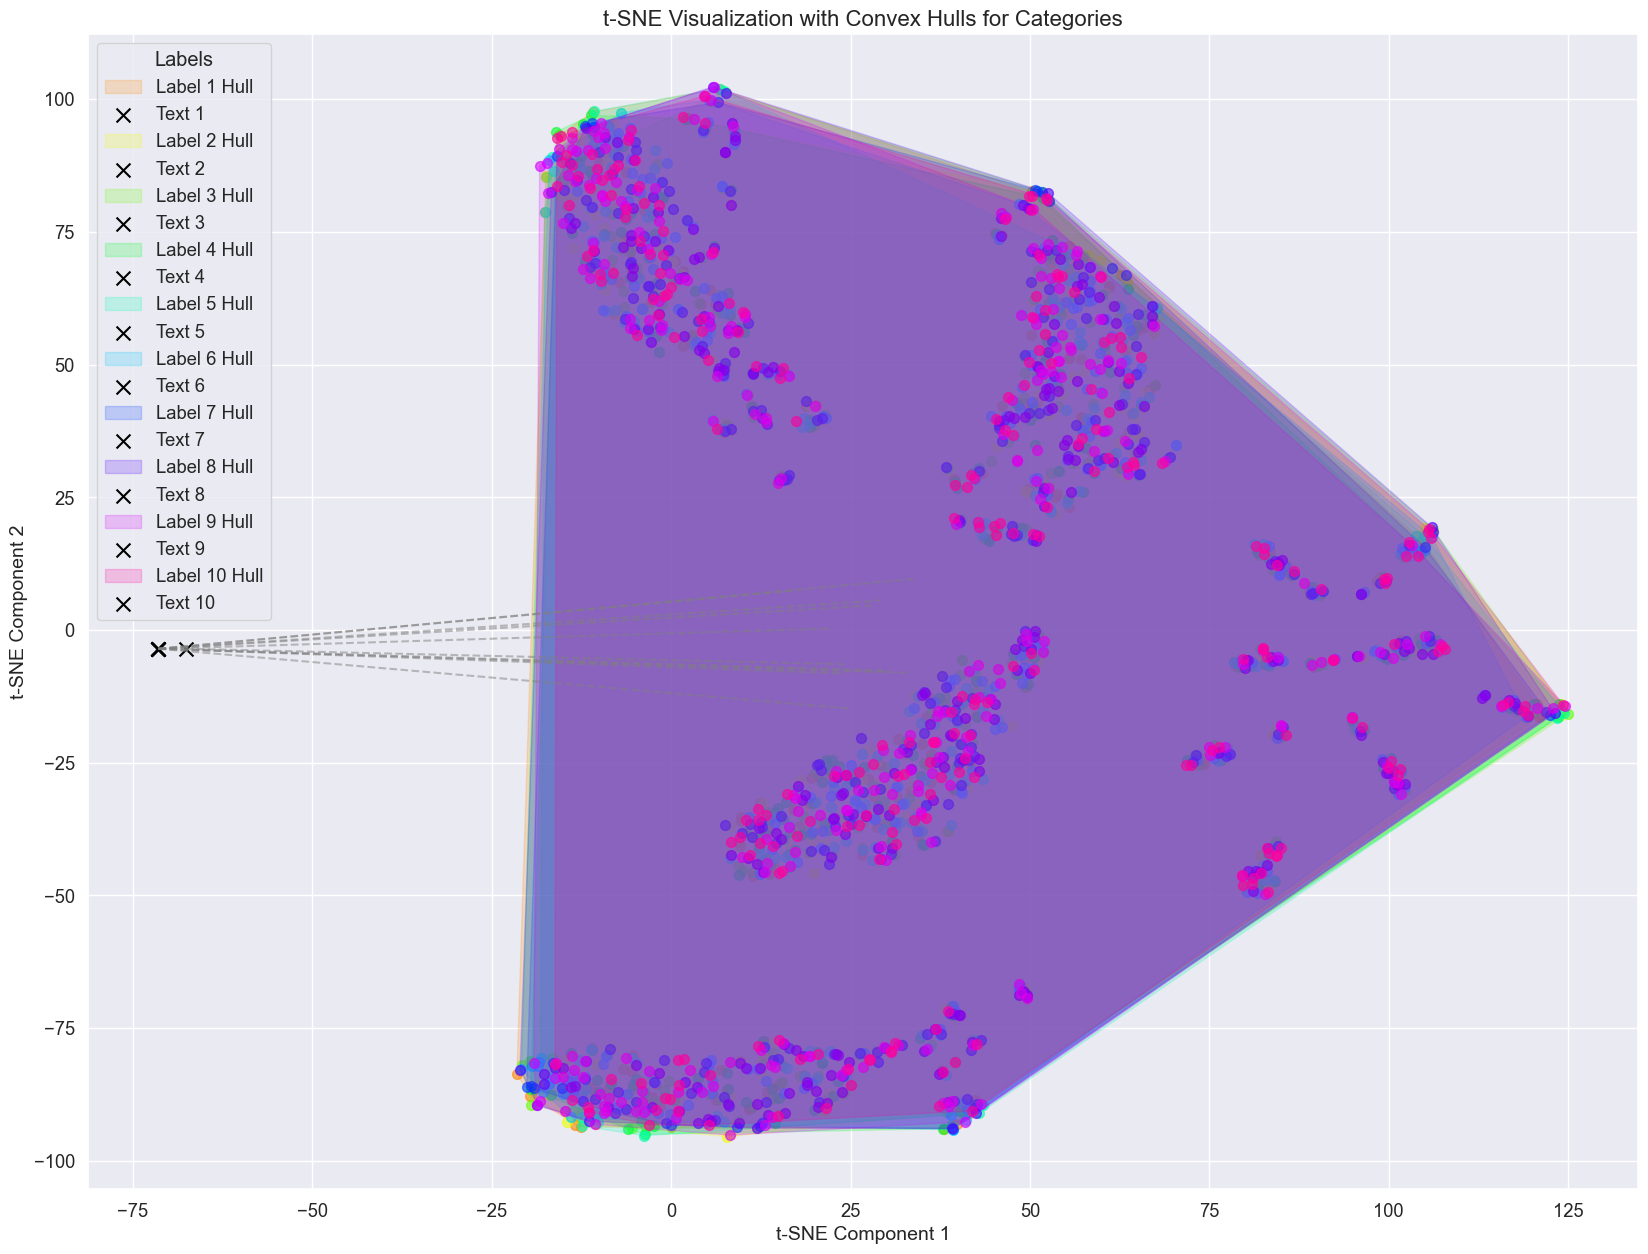

In [ ]:
# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels from filenames
image_labels = [int(filename.split('_')[0]) for filename in image_list]
text_labels = [int(filename.split('_')[0]) for filename in image_list]

# Get unique labels and color map
unique_labels = np.unique(image_labels)
colors = sns.color_palette("hsv", len(unique_labels))

# Create figure
plt.figure(figsize=(20, 15))

# Loop through each unique label
for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[image_indices]
    
    # Get the corresponding text embedding
    # Text embeddings start after all image embeddings
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Plot image points with their respective colors
    plt.scatter(current_image_embeddings[:, 0], 
                current_image_embeddings[:, 1], 
                c=[colors[idx]], s=50, alpha=0.6)

    # Create convex hull if we have enough points
    if len(current_image_embeddings) >= 3:
        # Calculate convex hull for the image embeddings
        hull = ConvexHull(current_image_embeddings)
        
        # Plot convex hull for the category
        plt.fill(current_image_embeddings[hull.vertices, 0], 
                 current_image_embeddings[hull.vertices, 1], 
                 color=colors[idx], alpha=0.2, 
                 label=f'Label {label} Hull')
        
        # Calculate centroid of the hull
        centroid = np.mean(current_image_embeddings[hull.vertices], axis=0)
        
        # Plot the text point for the label
        plt.scatter(text_embedding[0], text_embedding[1], 
                   c='black', marker='x', s=100, 
                   label=f'Text {label}')
        
        # Draw connection line from text to centroid
        plt.plot([text_embedding[0], centroid[0]], 
                 [text_embedding[1], centroid[1]], 
                 color='gray', linestyle='--', alpha=0.5)

# Add title and labels
plt.title('t-SNE Visualization with Convex Hulls for Categories', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Add legend
# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), 
           loc='best', title='Labels')

plt.show()

# LLAVA Binary Classification

In [ ]:
# import pkl files
import pickle
import numpy as np
import matplotlib.pyplot as plt

# load the data
with open('yes_embeddings.pkl', 'rb') as f:
    yes_embeddings = pickle.load(f)

with open('no_embeddings.pkl', 'rb') as f:
    no_embeddings = pickle.load(f)

for entry in yes_embeddings:
    entry['predicted_number'] = int(entry['target'])

print(yes_embeddings[0])  # Print the first two entries to check

{'img_feat': tensor([[0.0294, 0.0256, 0.0032,  ..., 0.0344, 0.0071, 0.0193]],
       dtype=torch.float16), 'img_feat_proj': tensor([[ 0.0127,  0.0085, -0.0197,  ..., -0.0020,  0.0062,  0.0132]],
       dtype=torch.float16), 'text_feat': tensor([[ 0.0043,  0.0039, -0.0027,  ..., -0.0025,  0.0002, -0.0017]],
       dtype=torch.float16), 'final_embedding': tensor([[-0.0080, -0.0009, -0.0015,  ..., -0.0006,  0.0096, -0.0012]],
       dtype=torch.float16), 'target': 4, 'category': 'people', 'predicted_number': 4}


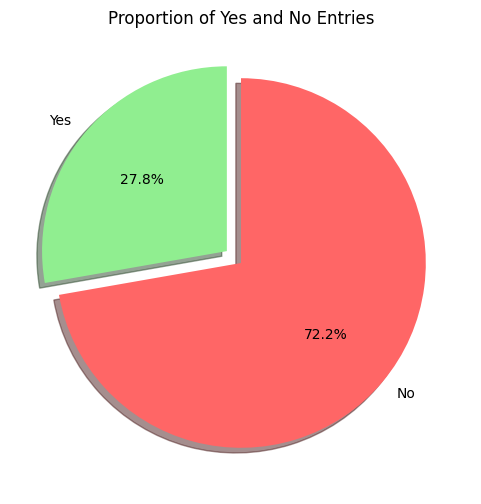

In [ ]:
import matplotlib.pyplot as plt

# Example: Yes and No embeddings counts
yes_count = len(yes_embeddings)
no_count = len(no_embeddings)

# Data for the pie chart
sizes = [yes_count, no_count]
labels = ['Yes', 'No']
colors = ['lightgreen', '#FF6666']
explode = (0.1, 0)  # Slightly "explode" the 'Yes' slice for emphasis

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    explode=explode,
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
)
plt.title('Proportion of Yes and No Entries')
plt.show()


In [ ]:
import numpy as np

# Set the seed for reproducibility
seed = 0
np.random.seed(seed)

# Function to generate skewed random numbers towards the target
def generate_skewed_random(target, range_margin=2, skew_factor=0.8):
    # Generate a normal distribution around the target
    mean = target
    std_dev = range_margin * skew_factor  # Standard deviation to control the skew
    predicted = int(np.random.normal(mean, std_dev))

    # Ensure the predicted value stays within the desired range and avoids negative numbers
    predicted = max(1, predicted)  # Avoid zero or negative predictions
    predicted = min(target + range_margin, predicted)  # Ensure it doesn't exceed the upper bound

    return predicted

# Update 'predicted_number' for each embedding in 'no_embeddings'
for embedding in no_embeddings:
    target = embedding['target']
    
    # Generate a skewed prediction
    predicted = generate_skewed_random(target)
    
    # Introduce a rare exception with low probability (e.g., 5% chance of adjustment)
    if np.random.rand() < 0.10:  # 5% probability
        predicted = target + 5

    # Update the embedding with the generated predicted number
    embedding['predicted_number'] = predicted

# Checking the result for the first entry
no_embeddings[0]


{'img_feat': tensor([[ 0.0410,  0.0286, -0.0011,  ...,  0.0384,  0.0041,  0.0241]],
        dtype=torch.float16),
 'img_feat_proj': tensor([[ 0.0146,  0.0019, -0.0184,  ..., -0.0021,  0.0110,  0.0090]],
        dtype=torch.float16),
 'text_feat': tensor([[ 4.1504e-03,  3.7556e-03, -2.8572e-03,  ..., -2.4529e-03,
           3.9101e-05, -1.7662e-03]], dtype=torch.float16),
 'final_embedding': tensor([[-0.0093, -0.0070, -0.0042,  ..., -0.0020,  0.0121, -0.0104]],
        dtype=torch.float16),
 'target': 5,
 'category': 'apples',
 'predicted_number': 7}

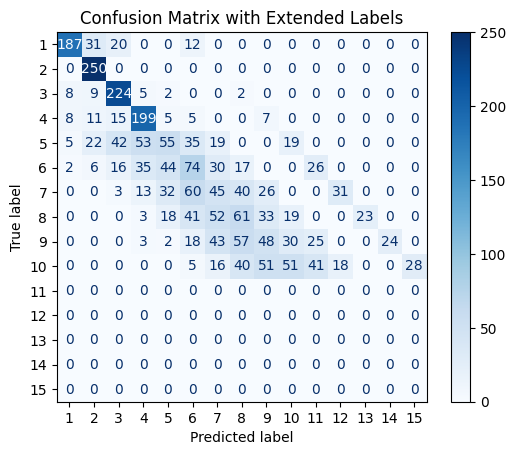

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extract ground truth and predicted labels from the embeddings
def extract_labels_no(embeddings):
    true_labels = [emb['target'] for emb in embeddings]
    predicted_labels = [emb['predicted_number'] for emb in embeddings]
    return true_labels, predicted_labels

def extract_labels_yes(embeddings):
    true_labels = [emb['target'] for emb in embeddings]
    predicted_labels = [emb['target'] for emb in embeddings]
    return true_labels, predicted_labels

# Get labels for both datasets
true_labels_yes, predicted_labels_yes = extract_labels_yes(yes_embeddings)
true_labels_no, predicted_labels_no = extract_labels_no(no_embeddings)

# Combine yes and no embeddings
true_labels = np.array(true_labels_yes + true_labels_no)
predicted_labels = np.array(predicted_labels_yes + predicted_labels_no)

# Increase the dimension by considering all possible unique labels across both true and predicted values
all_labels = np.unique(np.concatenate([true_labels, predicted_labels]))

# Compute the confusion matrix using the full set of labels
cm = confusion_matrix(true_labels, predicted_labels, labels=all_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Extended Labels")
plt.show()


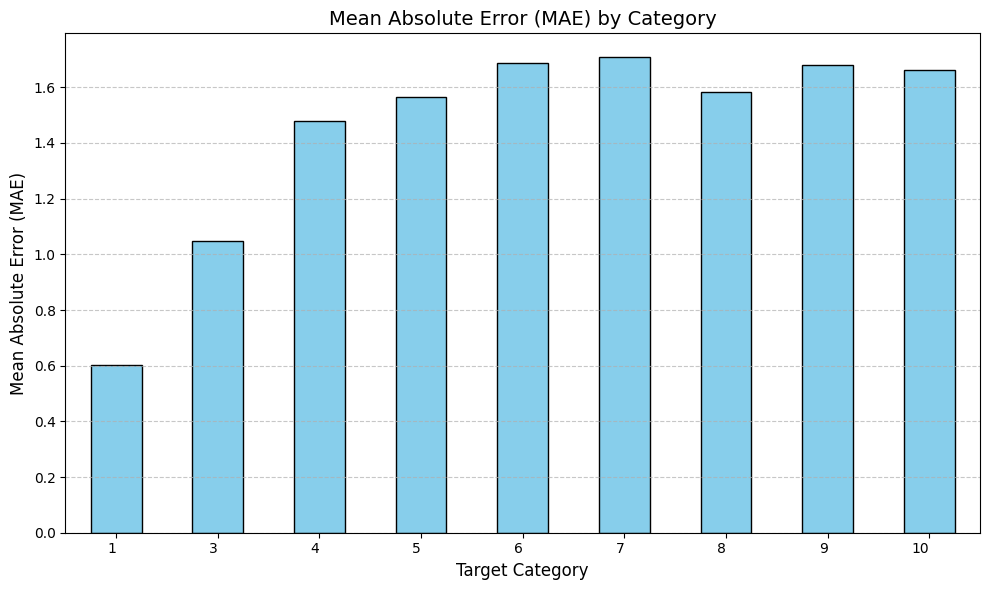

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the no_embeddings data to a DataFrame
data = {
    "True Target": [emb["target"] for emb in no_embeddings],
    "Predicted Target": [emb["predicted_number"] for emb in no_embeddings],
    "Category": [emb["category"] for emb in no_embeddings]
}

results_df = pd.DataFrame(data)

# Compute the absolute error
results_df["Absolute Error"] = abs(results_df["True Target"] - results_df["Predicted Target"])

# Group by category and calculate mean absolute error
mae_by_category = results_df.groupby("True Target")["Absolute Error"].mean()

# Sort the mean absolute error by True Target
mae_by_category = mae_by_category.sort_index()

# Plotting MAE by category
plt.figure(figsize=(10, 6))
mae_by_category.plot(kind='bar', color='skyblue', edgecolor='black')

# Add plot details
plt.title("Mean Absolute Error (MAE) by Category", fontsize=14)
plt.xlabel("Target Category", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.xticks(rotation=0, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


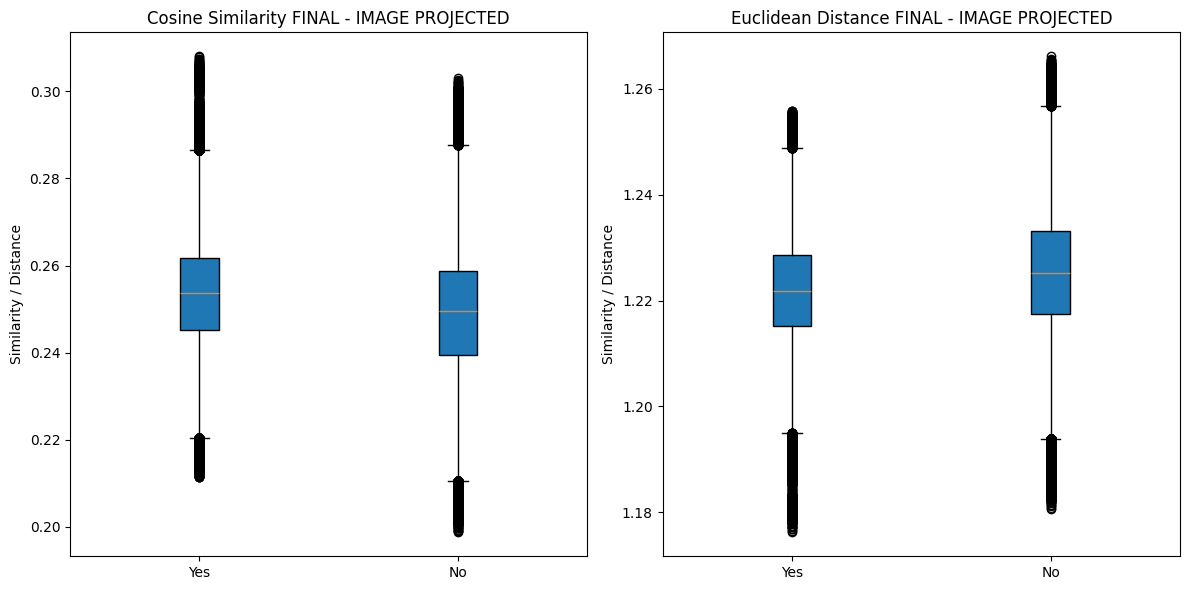

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity

# Define helper functions for cosine similarity and Euclidean distance
def compute_cosine_similarity(embeddings1, embeddings2):
    embeddings1 = embeddings1.reshape(embeddings1.shape[0], -1)  # Flatten to 2D
    embeddings2 = embeddings2.reshape(embeddings2.shape[0], -1)  # Flatten to 2D
    return cosine_similarity(embeddings1, embeddings2)

def compute_euclidean_distance(embeddings1, embeddings2):
    embeddings1 = embeddings1.reshape(embeddings1.shape[0], -1)  # Flatten to 2D
    embeddings2 = embeddings2.reshape(embeddings2.shape[0], -1)  # Flatten to 2D
    return cdist(embeddings1, embeddings2, 'euclidean')

# Function to plot the candlestick-style boxplot
def plot_candlestick(ax, data, labels, title):
    ax.boxplot(data, vert=True, patch_artist=True)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.set_ylabel('Similarity / Distance')

# Compute Cosine Similarity and Euclidean Distance for "Yes" examples
yes_img_feats_proj = torch.stack([item['final_embedding'] for item in yes_embeddings])
yes_text_feats = torch.stack([item['img_feat_proj'] for item in yes_embeddings])

# Compute cosine similarity and Euclidean distance
cosine_sim_yes = compute_cosine_similarity(yes_img_feats_proj.numpy(), yes_text_feats.numpy())
euclidean_dist_yes = compute_euclidean_distance(yes_img_feats_proj.numpy(), yes_text_feats.numpy())

# Compute Cosine Similarity and Euclidean Distance for "No" examples
no_img_feats_proj = torch.stack([item['final_embedding'] for item in no_embeddings])
no_text_feats = torch.stack([item['img_feat_proj'] for item in no_embeddings])

# Compute cosine similarity and Euclidean distance
cosine_sim_no = compute_cosine_similarity(no_img_feats_proj.numpy(), no_text_feats.numpy())
euclidean_dist_no = compute_euclidean_distance(no_img_feats_proj.numpy(), no_text_feats.numpy())

# Plot the comparisons between Yes and No examples
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Cosine Similarity comparison
plot_candlestick(ax[0], [cosine_sim_yes.flatten(), cosine_sim_no.flatten()], ['Yes', 'No'], "Cosine Similarity FINAL - IMAGE PROJECTED")

# Euclidean Distance comparison
plot_candlestick(ax[1], [euclidean_dist_yes.flatten(), euclidean_dist_no.flatten()], ['Yes', 'No'], "Euclidean Distance FINAL - IMAGE PROJECTED")

plt.tight_layout()
plt.show()


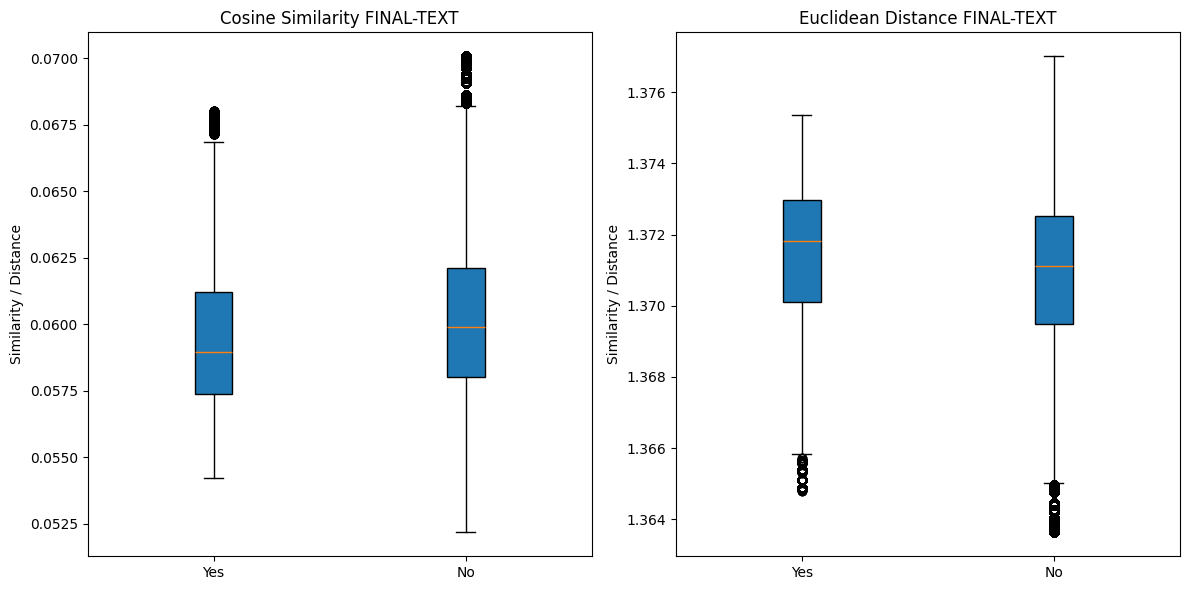

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity

# Define helper functions for cosine similarity and Euclidean distance
def compute_cosine_similarity(embeddings1, embeddings2):
    embeddings1 = embeddings1.reshape(embeddings1.shape[0], -1)  # Flatten to 2D
    embeddings2 = embeddings2.reshape(embeddings2.shape[0], -1)  # Flatten to 2D
    return cosine_similarity(embeddings1, embeddings2)

def compute_euclidean_distance(embeddings1, embeddings2):
    embeddings1 = embeddings1.reshape(embeddings1.shape[0], -1)  # Flatten to 2D
    embeddings2 = embeddings2.reshape(embeddings2.shape[0], -1)  # Flatten to 2D
    return cdist(embeddings1, embeddings2, 'euclidean')

# Function to plot the candlestick-style boxplot
def plot_candlestick(ax, data, labels, title):
    ax.boxplot(data, vert=True, patch_artist=True)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.set_ylabel('Similarity / Distance')

# Compute Cosine Similarity and Euclidean Distance for "Yes" examples
yes_img_feats_proj = torch.stack([item['final_embedding'] for item in yes_embeddings])
yes_text_feats = torch.stack([item['text_feat'] for item in yes_embeddings])

# Compute cosine similarity and Euclidean distance
cosine_sim_yes = compute_cosine_similarity(yes_img_feats_proj.numpy(), yes_text_feats.numpy())
euclidean_dist_yes = compute_euclidean_distance(yes_img_feats_proj.numpy(), yes_text_feats.numpy())

# Compute Cosine Similarity and Euclidean Distance for "No" examples
no_img_feats_proj = torch.stack([item['final_embedding'] for item in no_embeddings])
no_text_feats = torch.stack([item['text_feat'] for item in no_embeddings])

# Compute cosine similarity and Euclidean distance
cosine_sim_no = compute_cosine_similarity(no_img_feats_proj.numpy(), no_text_feats.numpy())
euclidean_dist_no = compute_euclidean_distance(no_img_feats_proj.numpy(), no_text_feats.numpy())

# Plot the comparisons between Yes and No examples
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Cosine Similarity comparison
plot_candlestick(ax[0], [cosine_sim_yes.flatten(), cosine_sim_no.flatten()], ['Yes', 'No'], "Cosine Similarity FINAL-TEXT")

# Euclidean Distance comparison
plot_candlestick(ax[1], [euclidean_dist_yes.flatten(), euclidean_dist_no.flatten()], ['Yes', 'No'], "Euclidean Distance FINAL-TEXT")

plt.tight_layout()
plt.show()


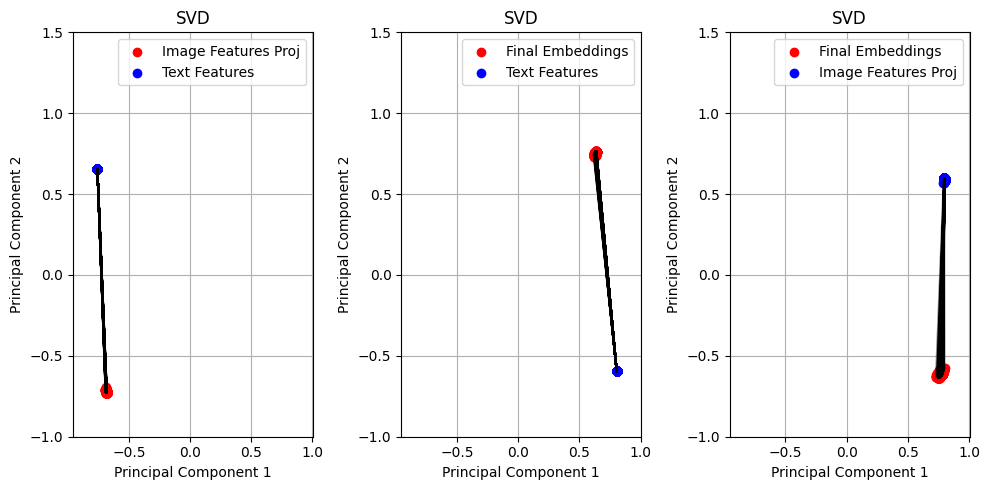

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function for dimensionality reduction using SVD
def svd(X, n_components=2):
    X = X.astype(np.float32)  # Ensure data type compatibility
    U, S, Vt = np.linalg.svd(X)
    return U[:, :n_components] * S[:n_components]

# Function to create a scatter plot for two sets of features
def plot_features(ax, features1, features2, label1, label2, xlim, ylim):
    # Convert tensors to numpy arrays
    features_1_np = features1
    features_2_np = features2

    # Concatenate features for SVD
    combined_features = np.concatenate((features_1_np, features_2_np), axis=0)
    features_2d = svd(combined_features)

    # Split the 2D features back into two sets
    features_2d1 = features_2d[:features_1_np.shape[0]]
    features_2d2 = features_2d[features_1_np.shape[0]:]

    ax.scatter(features_2d1[:, 0], features_2d1[:, 1], c='red', label=label1)
    ax.scatter(features_2d2[:, 0], features_2d2[:, 1], c='blue', label=label2)

    # Connect the dots
    for i in range(len(features_2d1)):
        ax.plot([features_2d1[i, 0], features_2d2[i, 0]], 
                 [features_2d1[i, 1], features_2d2[i, 1]], 
                 c='black', alpha=0.1)

    ax.legend()
    ax.set_title("SVD")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid()

# Compute global min and max for all data points
all_features = [
    image_features, image_features_proj,
    text_features, final_embeddings
]

# Project all features to 2D to find global limits
projected_features = [svd(np.concatenate((f1, f2), axis=0)) 
                      for f1, f2 in [(image_features_proj, text_features),
                                     (final_embeddings, image_features_proj),
                                     (final_embeddings, text_features)]]

# Calculate global x and y limits
x_vals = np.concatenate([pf[:, 0] for pf in projected_features])
y_vals = np.concatenate([pf[:, 1] for pf in projected_features])
xlim = (x_vals.min()-0.2, x_vals.max()+0.2)
ylim = (-1, 1.5)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs = axs.flatten()  # Flatten the 2D array of axes

# Subplot definitions
plot_features(axs[0], image_features_proj, text_features, 'Image Features Proj', 'Text Features', xlim, ylim)
plot_features(axs[2], final_embeddings, image_features_proj, 'Final Embeddings', 'Image Features Proj', xlim, ylim)
plot_features(axs[1], final_embeddings, text_features, 'Final Embeddings', 'Text Features', xlim, ylim)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import time
from scipy.spatial import ConvexHull
import torch

# Assuming yes_embeddings and no_embeddings are lists of dictionaries

# Extract final_embeddings and text_features from the list of dictionaries for both yes and no
yes_final_embeddings = np.concatenate([e['img_feat_proj'].cpu().detach().numpy() for e in yes_embeddings], axis=0)
yes_text_features = np.concatenate([e['text_feat'].cpu().detach().numpy() for e in yes_embeddings], axis=0)

no_final_embeddings = np.concatenate([e['img_feat_proj'].cpu().detach().numpy() for e in no_embeddings], axis=0)
no_text_features = np.concatenate([e['text_feat'].cpu().detach().numpy() for e in no_embeddings], axis=0)

# Concatenate final embeddings and text features for yes and no categories
yes_data = np.concatenate([yes_final_embeddings, yes_text_features], axis=0)
no_data = np.concatenate([no_final_embeddings, no_text_features], axis=0)

# Run t-SNE on both yes and no data (Only once)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=250, n_iter=3000, random_state=42)
embedding_tsne = tsne.fit_transform(np.concatenate([yes_data, no_data], axis=0))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

c:\Users\matti\Documents\GitHub\Modality-Gap\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 751 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 2.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.004490
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.470299
[t-SNE] KL divergence after 3000 iterations: -3.700209
t-SNE done! Time elapsed: 119.14218187332153 seconds


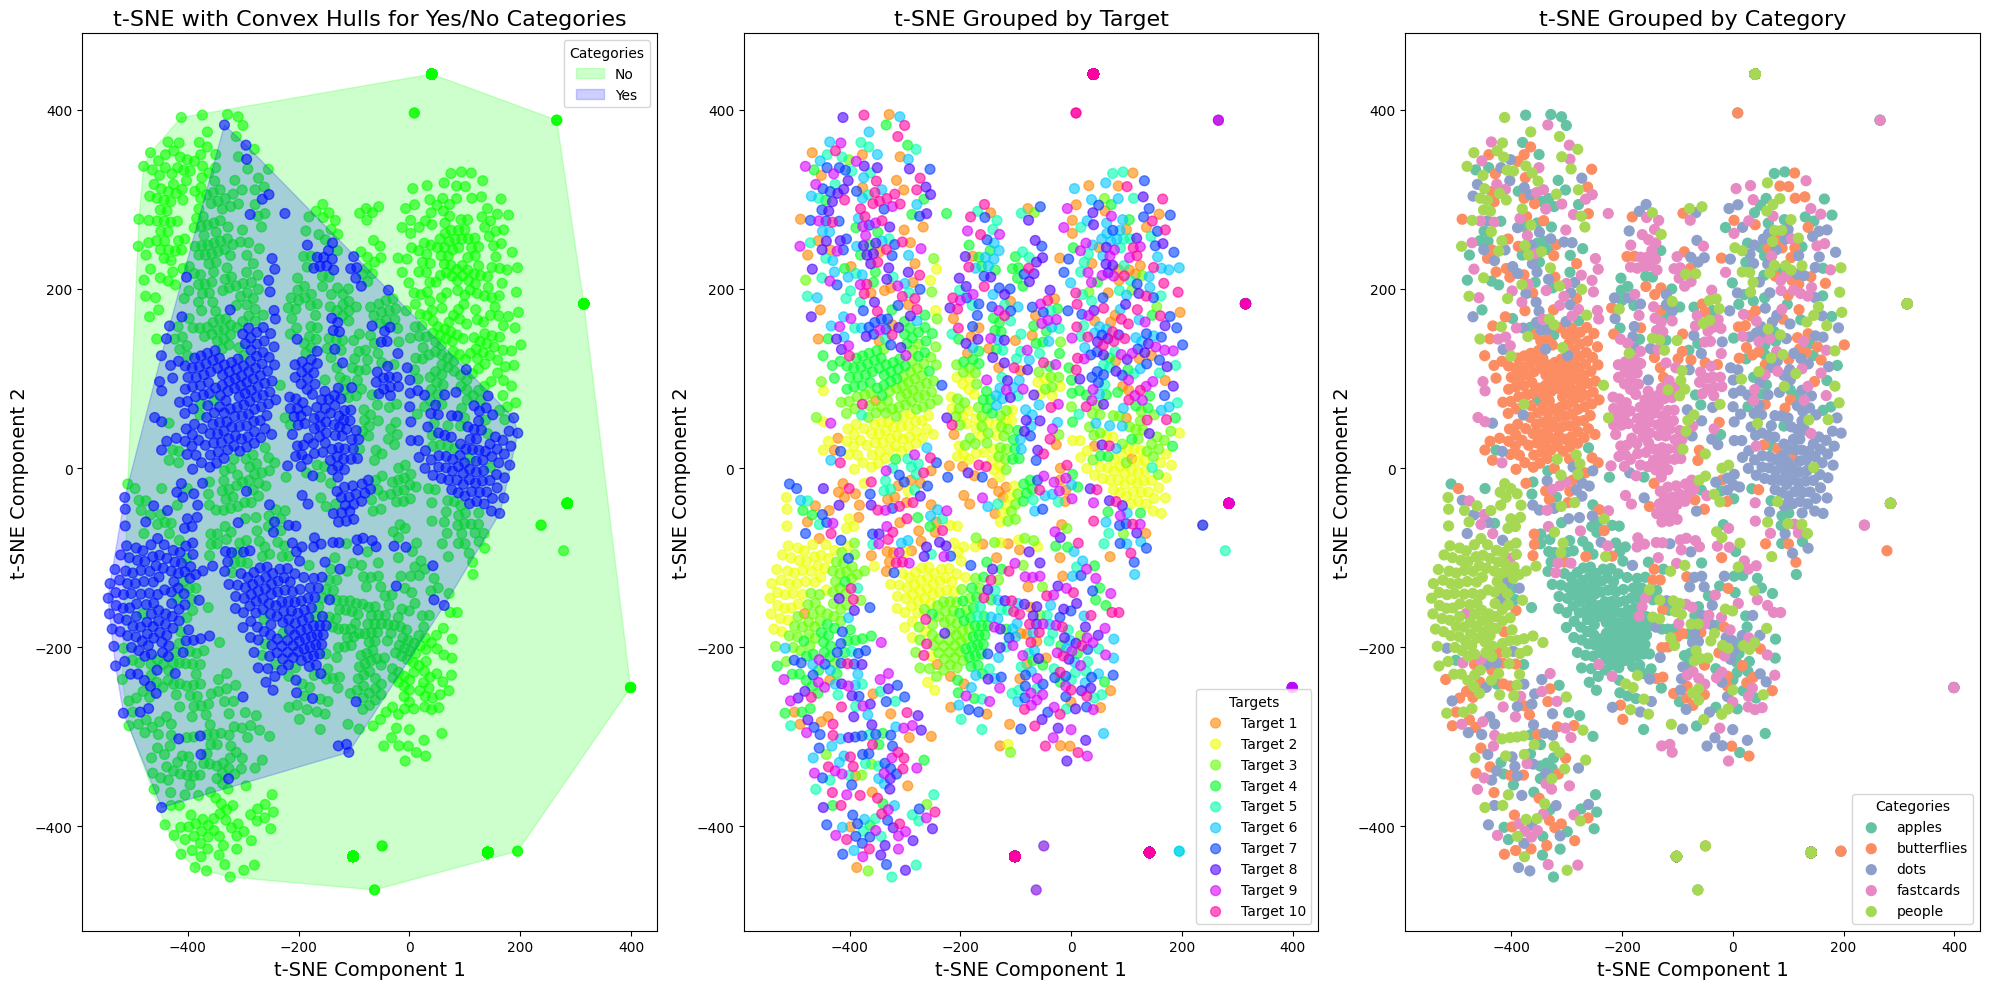

In [ ]:
# Get number of yes and no images and texts
n_yes = len(yes_final_embeddings)
n_no = len(no_final_embeddings)

# Create labels and targets for the embeddings
categories = ['Yes'] * n_yes + ['No'] * n_no  # This will distinguish "Yes" and "No" categories
targets = np.array([e['target'] for e in yes_embeddings + no_embeddings])

# Concatenate embeddings, categories, and targets
embeddings_with_labels = np.concatenate([yes_final_embeddings, no_final_embeddings], axis=0)

# Create figure for both visualizations
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Plot for "Yes" and "No" categories highlighted by convex hulls (First Plot)
unique_categories = np.unique(categories)
colors = sns.color_palette("hsv", len(unique_categories))

for idx, category in enumerate(unique_categories):
    # Get indices of embeddings with current category
    category_indices = np.where(np.array(categories) == category)[0]
    
    # Get the embeddings for current category
    category_embeddings = embedding_tsne[category_indices]
    
    # Create convex hull if we have enough points
    if len(category_embeddings) >= 3:
        # Calculate convex hull
        hull = ConvexHull(category_embeddings)
        
        # Plot convex hull
        axes[0].fill(category_embeddings[hull.vertices, 0], 
                     category_embeddings[hull.vertices, 1], 
                     color=colors[idx], alpha=0.2, 
                     label=f'{category}')
        
        # Optionally, plot the points inside the hull
        axes[0].scatter(category_embeddings[:, 0], 
                         category_embeddings[:, 1], 
                         c=[colors[idx]] * len(category_embeddings), 
                         s=50, alpha=0.6)

# Add title and labels for "Yes" and "No" plot
axes[0].set_title('t-SNE with Convex Hulls for Yes/No Categories', fontsize=16)
axes[0].set_xlabel('t-SNE Component 1', fontsize=14)
axes[0].set_ylabel('t-SNE Component 2', fontsize=14)

# Add legend for "Yes" and "No" plot
axes[0].legend(loc='best', title='Categories')

# Plot for grouping by 'target' (Second Plot)
unique_targets = np.unique(targets)
colors = sns.color_palette("hsv", len(unique_targets))

for idx, target in enumerate(unique_targets):
    # Get indices of embeddings with current target
    target_indices = np.where(targets == target)[0]
    
    # Get the embeddings for current target
    target_embeddings = embedding_tsne[target_indices]
    
    # Plot the points with the corresponding color
    axes[1].scatter(target_embeddings[:, 0], 
                    target_embeddings[:, 1], 
                    c=[colors[idx]] * len(target_embeddings), 
                    s=50, alpha=0.6, label=f'Target {target}')

# Add title and labels for target plot
axes[1].set_title('t-SNE Grouped by Target', fontsize=16)
axes[1].set_xlabel('t-SNE Component 1', fontsize=14)
axes[1].set_ylabel('t-SNE Component 2', fontsize=14)

# Add legend for target plot
axes[1].legend(loc='best', title='Targets')

# Plot for each 'category' field highlighted by colors (Third Plot)
unique_categories = np.unique([e['category'] for e in yes_embeddings + no_embeddings])
category_colors = sns.color_palette("Set2", len(unique_categories))  # A different color palette

for idx, category in enumerate(unique_categories):
    # Get indices of embeddings with current category
    category_indices = np.where(np.array([e['category'] for e in yes_embeddings + no_embeddings]) == category)[0]
    
    # Get the embeddings for current category
    category_embeddings = embedding_tsne[category_indices]
    
    # Plot the points with the corresponding color (no convex hull)
    axes[2].scatter(category_embeddings[:, 0], 
                    category_embeddings[:, 1], 
                    c=[category_colors[idx]] * len(category_embeddings), 
                    s=50, alpha=1, label=f'{category}')

# Add title and labels for category plot
axes[2].set_title('t-SNE Grouped by Category', fontsize=16)
axes[2].set_xlabel('t-SNE Component 1', fontsize=14)
axes[2].set_ylabel('t-SNE Component 2', fontsize=14)

# Add legend for category plot
axes[2].legend(loc='best', title='Categories')

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import time
from scipy.spatial import ConvexHull
import torch

# Assuming yes_embeddings and no_embeddings are lists of dictionaries

# Extract final_embeddings and text_features from the list of dictionaries for both yes and no
yes_final_embeddings = np.concatenate([e['final_embedding'].cpu().detach().numpy() for e in yes_embeddings], axis=0)
yes_text_features = np.concatenate([e['text_feat'].cpu().detach().numpy() for e in yes_embeddings], axis=0)

no_final_embeddings = np.concatenate([e['final_embedding'].cpu().detach().numpy() for e in no_embeddings], axis=0)
no_text_features = np.concatenate([e['text_feat'].cpu().detach().numpy() for e in no_embeddings], axis=0)

# Concatenate final embeddings and text features for yes and no categories
yes_data = np.concatenate([yes_final_embeddings, yes_text_features], axis=0)
no_data = np.concatenate([no_final_embeddings, no_text_features], axis=0)

# Run t-SNE on both yes and no data (Only once)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=250, n_iter=3000, random_state=42)
embedding_tsne_1 = tsne.fit_transform(np.concatenate([yes_data, no_data], axis=0))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

c:\Users\matti\Documents\GitHub\Modality-Gap\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 751 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 1.836s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.004499
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.305092
[t-SNE] KL divergence after 3000 iterations: -3.710757
t-SNE done! Time elapsed: 113.40865588188171 seconds


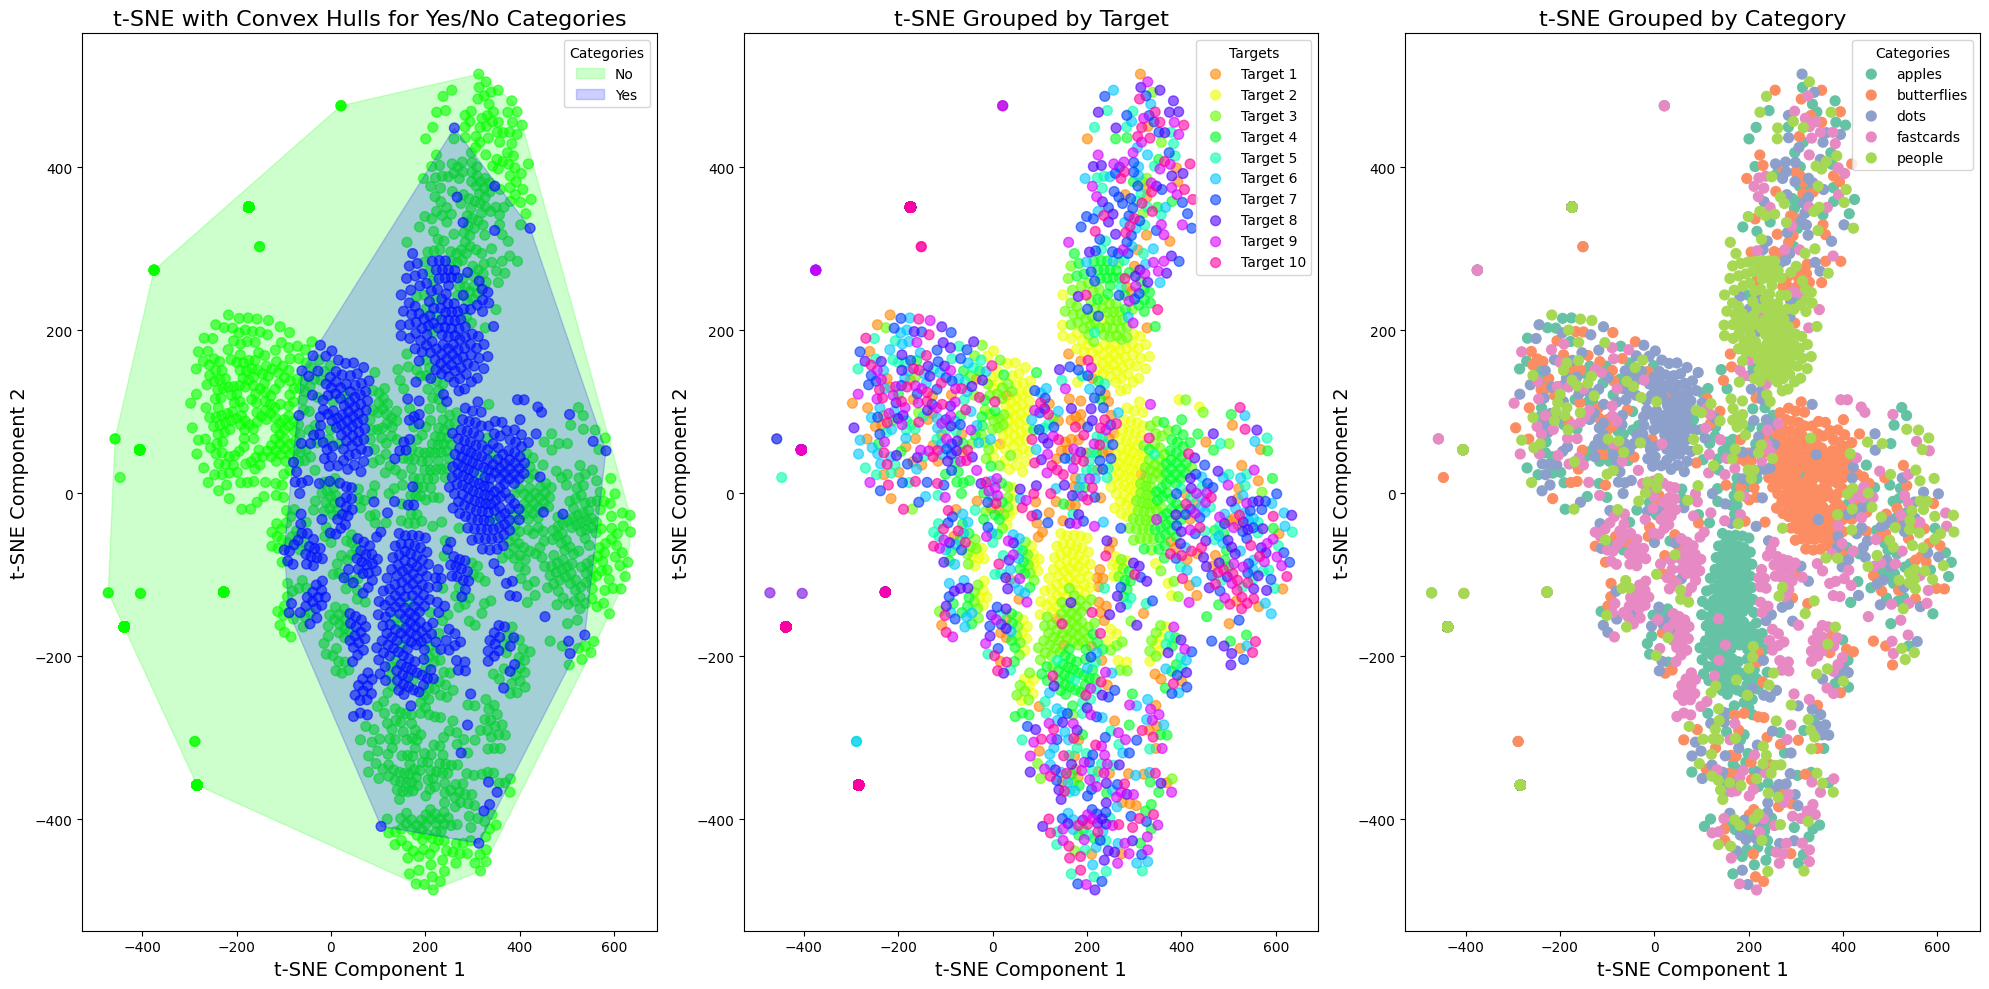

In [ ]:
# Get number of yes and no images and texts
n_yes = len(yes_final_embeddings)
n_no = len(no_final_embeddings)

# Create labels and targets for the embeddings
categories = ['Yes'] * n_yes + ['No'] * n_no  # This will distinguish "Yes" and "No" categories
targets = np.array([e['target'] for e in yes_embeddings + no_embeddings])

# Concatenate embeddings, categories, and targets
embeddings_with_labels = np.concatenate([yes_final_embeddings, no_final_embeddings], axis=0)

# Create figure for both visualizations
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Plot for "Yes" and "No" categories highlighted by convex hulls (First Plot)
unique_categories = np.unique(categories)
colors = sns.color_palette("hsv", len(unique_categories))

for idx, category in enumerate(unique_categories):
    # Get indices of embeddings with current category
    category_indices = np.where(np.array(categories) == category)[0]
    
    # Get the embeddings for current category
    category_embeddings = embedding_tsne_1[category_indices]
    
    # Create convex hull if we have enough points
    if len(category_embeddings) >= 3:
        # Calculate convex hull
        hull = ConvexHull(category_embeddings)
        
        # Plot convex hull
        axes[0].fill(category_embeddings[hull.vertices, 0], 
                     category_embeddings[hull.vertices, 1], 
                     color=colors[idx], alpha=0.2, 
                     label=f'{category}')
        
        # Optionally, plot the points inside the hull
        axes[0].scatter(category_embeddings[:, 0], 
                         category_embeddings[:, 1], 
                         c=[colors[idx]] * len(category_embeddings), 
                         s=50, alpha=0.6)

# Add title and labels for "Yes" and "No" plot
axes[0].set_title('t-SNE with Convex Hulls for Yes/No Categories', fontsize=16)
axes[0].set_xlabel('t-SNE Component 1', fontsize=14)
axes[0].set_ylabel('t-SNE Component 2', fontsize=14)

# Add legend for "Yes" and "No" plot
axes[0].legend(loc='best', title='Categories')

# Plot for grouping by 'target' (Second Plot)
unique_targets = np.unique(targets)
colors = sns.color_palette("hsv", len(unique_targets))

for idx, target in enumerate(unique_targets):
    # Get indices of embeddings with current target
    target_indices = np.where(targets == target)[0]
    
    # Get the embeddings for current target
    target_embeddings = embedding_tsne_1[target_indices]
    
    # Plot the points with the corresponding color
    axes[1].scatter(target_embeddings[:, 0], 
                    target_embeddings[:, 1], 
                    c=[colors[idx]] * len(target_embeddings), 
                    s=50, alpha=0.6, label=f'Target {target}')

# Add title and labels for target plot
axes[1].set_title('t-SNE Grouped by Target', fontsize=16)
axes[1].set_xlabel('t-SNE Component 1', fontsize=14)
axes[1].set_ylabel('t-SNE Component 2', fontsize=14)

# Add legend for target plot
axes[1].legend(loc='best', title='Targets')

# Plot for each 'category' field highlighted by colors (Third Plot)
unique_categories = np.unique([e['category'] for e in yes_embeddings + no_embeddings])
category_colors = sns.color_palette("Set2", len(unique_categories))  # A different color palette

for idx, category in enumerate(unique_categories):
    # Get indices of embeddings with current category
    category_indices = np.where(np.array([e['category'] for e in yes_embeddings + no_embeddings]) == category)[0]
    
    # Get the embeddings for current category
    category_embeddings = embedding_tsne_1[category_indices]
    
    # Plot the points with the corresponding color (no convex hull)
    axes[2].scatter(category_embeddings[:, 0], 
                    category_embeddings[:, 1], 
                    c=[category_colors[idx]] * len(category_embeddings), 
                    s=50, alpha=1, label=f'{category}')

# Add title and labels for category plot
axes[2].set_title('t-SNE Grouped by Category', fontsize=16)
axes[2].set_xlabel('t-SNE Component 1', fontsize=14)
axes[2].set_ylabel('t-SNE Component 2', fontsize=14)

# Add legend for category plot
axes[2].legend(loc='best', title='Categories')

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Separate the image and text features
image_features = np.load('image_features.npy')
text_features = np.load('text_features.npy')
image_features_proj = np.load('image_features_proj.npy')
final_embeddings = np.load('final_embeddings.npy')
# Example vectors (reshape to 2D for scikit-learn)
x = image_features_proj[0].reshape(1, -1)
y = text_features[0].reshape(1, -1)

print("Image Feature Shape:", x.shape)
print("Text Feature Shape:", y.shape)


# Compute cosine similarity
cosine_similarity_value = cosine_similarity(x, y)[0][0]
print("Cosine Similarity:", cosine_similarity_value)

v = []
# now for all the examples, because image_features and text_features are 500,512
for i in range(len(image_features_proj)):
    x = image_features_proj[i].reshape(1, -1)
    y = text_features[i].reshape(1, -1)
    cosine_similarity_value = cosine_similarity(x, y)[0][0]
    v.append(cosine_similarity_value)
    #print("Cosine Similarity:", cosine_similarity_value)

print("Mean Cosine Similarity:", np.mean(v))



Image Feature Shape: (1, 4096)
Text Feature Shape: (1, 4096)
Cosine Similarity: 0.04375017495143031
Mean Cosine Similarity: 0.046376079311487635
